In [3]:
"""Data acquisition module.

The sets of functions here help to gather the data from the source.

Authors: 
"""

import re
import numpy as np
from astropy.table import Table, vstack

def cut(c):
    """Cut the data by a patron defined and return a tuple.

    Keyword arguments:
    data -- the data to cut, list
    
    """
    flag = True
    data = []
    head = []
    patron = re.compile("\s+")
    for i in c:
        if flag == True:
            head.append(patron.split(i))
            flag = False
        else:
            data.append(patron.split(i))
    return np.array(data),head

def parser(data,n=10):
    """Transform data from source txt to an structure and return a astropy.table.

    Keyword arguments:
    data -- the data to transform, list
    
    """
    c = []
    alpha = []
    gamma = []
    flag = 0
    flag1 = False
    typ= ('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8',np.str,'f8',np.str,np.str)
    for i in range(len(data)):
        flag1= re.findall("\# ######### LIGHT ",data[i])
        if flag1:
            data= data[i+1:]
            break
    try:
        for i in range(len(data)):
            head = re.findall("\A#\s+(.+)",data[i])
            new_line = re.findall("\A   (.+)",data[i]) 
            ra = re.findall("\#ra=\s+(.+)",data[i])
            dec = re.findall("\#dec=\s+(.+)",data[i])

            if ra:
                ra_aux = ra
            if dec:
                dec_aux = dec
            if head:
                [c.append(j) for j in head]
            if new_line:
                [c.append(k) for k in new_line]
                alpha.append(ra_aux)
                gamma.append(dec_aux)
                try:
                    next_line = re.findall("\A   (.+)",data[i+1])
                    if not next_line:
                        reg, col= cut(c)
                        if len(reg) == len(alpha)+1 :
                            reg = reg[1:len(reg)+1]
                        if flag == 0:
                            col[0].append('RA')
                            col[0].append('DEC')
                            reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                            t = Table(reg, names=tuple(col[0]), dtype = typ)
                            c = []
                            alpha = []
                            gamma = []
                            flag += 1
                        else:
                            col[0].append('RA')
                            col[0].append('DEC')
                            reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                            t_aux = Table(reg, names=tuple(col[0]), dtype = typ)
                            t = vstack([t, t_aux])
                            c = []
                            alpha = []
                            gamma = []

                except:
                    reg, col = cut(c)
                    if flag == 0:
                        col[0].append('RA')
                        col[0].append('DEC')
                        reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                        t = Table(reg, names=tuple(col[0]), dtype = typ)
                        c = []
                        alpha = []
                        gamma = []
                        flag += 1   
                    else:
                        col[0].append('RA')
                        col[0].append('DEC')
                        reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                        t_aux = Table(reg, names=tuple(col[0]), dtype = typ)
                        t = vstack([t, t_aux])
        return t if len(t)>=n else t[:0].copy()
    except:
        return -1

In [4]:
"""Preprocessing module.

The sets of functions here help from the perspective of preprocessing, complementing
the module of data gathering and features extraction.

Authors: 
"""

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
        
def outliers_iqr(data_col, aperture='0'):
    """Delete atypical data and return a astropy.table.

    Keyword argument:
    ys -- the data, {np.narray, astropy.table, astropy.table.column}
    aperture -- the aperture index, str
    
    """
    if (type(data_col)==Table):
        quartile_1, quartile_3 = np.percentile(data_col['MAG_'+aperture], [25,75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr*1.5)
        upper_bound = quartile_3 + (iqr*1.5)
        res = data_col[np.where((data_col['MAG_'+aperture] <= upper_bound) & (data_col['MAG_'+aperture] >= lower_bound))]
        
    else:
        quartile_1, quartile_3 = np.percentile(data_col, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr*1.5)
        upper_bound = quartile_3 + (iqr*1.5)
        res = data_col[np.where((data_col <= upper_bound) & (data_col >= lower_bound))]
        if (type(data_col)==Table.Column):
            res = Table([res], names=(data_col.name,), dtype=('f8',))
            res.meta = data_col.meta
        else:
            res = Table([res], names=('MAG_'+'i', ))
    return res
        
def high_photometric_errors(data_col, aperture='0'):
    """Delete high photometric errors and return a astropy.table.

    Keyword argument:
    data -- the data to analyze, {np.narray, astropy.table, astropy.table.column}
    aperture -- the aperture index, str
    
    """
    if (type(data_col)==Table):    
        mer_mean = np.mean(data_col['MER_'+aperture])
        mer_std = np.std(data_col['MER_'+aperture])
        error_limit = mer_mean + 3*mer_std
        res = data_col[np.where(data_col['MER_'+aperture] < error_limit)]

    else:
        mer_mean = np.mean(data_col)
        mer_std = np.std(data_col)
        error_limit = mer_mean + 3*mer_std
        res = data_col[np.where(data_col < error_limit)]
        if (type(data_col)==Table.Column):
            res = Table([res], names=(data_col.name,), dtype=('f8',))
            res.meta = data_col.meta
        else:
            res = Table([res], names=('MER_'+'i', ))
    return res

# funcion que hace todo el preprocesamiento
def preprocessing(data,aperture):
    """Preprocess data for an aperture and return a astropy.table.

    Keyword arguments:
    data -- the data to analyze, {np.narray, astropy.table, astropy.table.column}
    aperture -- the aperture index, str
    
    """
    # 1 - se eliminan las mediciones con alto error fotometrico
    data_aux = high_photometric_errors(data,aperture)
    #2 - se eliminan datos atípicos
    data_aux = outliers_iqr(data_aux,aperture)
    # Se retornan los dias julianos y la magnitud de la apertura seleccionada
    return data_aux


In [5]:
"""Features extraction module.

The objective of this module is analyze the preprocessed light curves.

Authors: 
"""

from scipy.optimize import curve_fit
import numpy as np
from astropy.table import unique

def lineal_fit(t,a,b):
    """Lineal fit to data and return param m np.narray.

    Keyword arguments:
    t -- A np.narray
    a -- A float
    b -- A float
    
    """
    m = a+b*t
    return m

def parabolic_fit(t,a,b,c):
    """Parabolic fit to data and return param m np.narray.

    Keyword arguments:
    t -- A np.narray
    a -- A float
    b -- A float
    c -- A float
    
    """
    m = a + b*t + c*t*t
    return m

# Por ahora fit puede ser lineal o parabolico
def get_statistics(t,y):
    """Obtain and return Q1', C1, Q2' and C2.

    Keyword arguments:
    t -- A np.narray, astropy.table.column
    y -- A np.narray, astropy.table.column
    
    """
    # Desviacion estandar y
    dep = np.std(y)
    #para fit lineal
    poptl, pcovl = curve_fit(lineal_fit, t, y)
    y_hatl = lineal_fit(t,*poptl)
    perrl = np.sqrt(np.diag(pcovl))
    defl = np.sqrt(np.sum((y_hatl- y)*(y_hatl- y))/len(y))
    q1 = poptl[1]/perrl[1]
    c1 = 1-(defl/dep)
    # Para fit parabolico
    poptp, pcovp = curve_fit(parabolic_fit, t, y)
    y_hatp = parabolic_fit(t,*poptp)
    perrp = np.sqrt(np.diag(pcovp))
    defp = np.sqrt(np.sum((y_hatp- y)*(y_hatp- y))/len(y))
    q2 = poptp[2]/perrp[2]
    c2 = 1-(defp/defl)
    stat = [q1,c1,q2,c2]
    return stat

def get_ra_dec(data):
    """Obtain and return RA and DEC, both str.
    
    RA is the Right Ascencion.
    DEC is the Declination.

    Keyword arguments:
    data -- the data to analyze, astropy.table
    
    """
    ra= data['RA'][0].split(" ")[0]
    dec= data['DEC'][0].split(" ")[0]
    return ra,dec

def select_unique(data,cols):
    """Obtain and return RA and DEC, both str.
    
    RA is the Right Ascencion.
    DEC is the Declination.

    Keyword arguments:
    data -- the data to analyze, astropy.table
    
    """

    res = unique(data,  keys=cols)
    row = []
    for i in range(len(res)):
        ra = float(res['RA'][i].split(" ")[0])
        dec = float(res['DEC'][i].split(" ")[0])
        row.append([ra,dec])
    return np.array(row)

In [6]:
"""Filter module.

The objective of this module is to classify each star by his light curve's
params obtained from features extraction module, filtering by a group of 
thresholds the stars that are not periodic large variable.

Authors: 
"""
from astropy.table import Table,join
import numpy as np

def grade_filter(data,grades):
    """Filter the data to preprocess and return a astropy.table.

    Keyword arguments:
    data -- the data to analyze, astropy.table
    grades -- the grades to analyze, tuple
    
    """
    data_aux = Table([grades], names=['GRADE'])
    res = join(data, data_aux, join_type='right')
    if (len(res)) == 0:
        print("there's no values asociated with "+str(grades)+" apertures, no table returned")
        return -1
    if res.masked:
        del res[res['HJD'].mask.nonzero()[0]]
    return res

def stars_Cfilter(data, ThC1=0.02, ThC2=0.02):
    """Filter the data by thresholds and return the filtered data as astropy.table.
    
    ThreshC1 -- the threshold for C1
    ThreshC2 -- the threshold for C2
    
    """
    return data[np.where((data['C1']>=ThC1)&(data['C2']>=ThC2))]
    
def stars_Qfilter(data, ThQ1=4, ThQ2=4):
    """Filter the data by thresholds and return the filtered data as astropy.table.
    
    ThreshC1 -- the threshold for C1
    ThreshC2 -- the threshold for C2
    
    """
    return data[np.where((data['Q1']>=ThQ1)&(data['Q2']>=ThQ2))]


In [ ]:
""" Utilities

"""
    
def _Sort(tup):
    """Sort a tuple in descending order and return a tuple.

    Keyword arguments:
    tup -- tuple to sort, tuple
    
    """
    # reverse = True (Sorts in Descending order)
    return(sorted(tup, key = lambda x: float(x[0]), reverse = True))
        
def _graph(data,path,title):
    """Graph in a scatter type and save to a folder.

    Keyword arguments:
    data -- the data to graph, tuple
    path -- the path to save, str
    title -- the graph title, str
    
    """
    data = Sort(data)
    fig, ax = plt.subplots()
    ax.scatter(data[0],data[1])
    ax.set(xlabel='HJD', ylabel='Magnitude',
           title=title)
    ax.grid()
    fig.savefig(path+"/"+title+"_fig.png")
    
def grades():
    """Ask for grades to keyboard input and return a list with the keyboard input."""
    try:
        grades = input('Select GRADE, usage "A,B,..." with valid options A,B,C,D: ')
        if not(set(grades.split(",")) <= {'A','B','C','D'}):
            raise ValueError(grades)
        return grades.split(",")
    except ValueError:
        print("incorrect GRADE, ingressed: ",grades)
        raise
        
def mags():
    """Ask for magnitudes to keyboard input and return a tuple."""
    try:
        mags = input('Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight: ')
        if (int(max(set(mags.split(",")))) > 1):
            raise ValueError(mags)
        return tuple(mags.split(","))
    except ValueError:
        print("incorrect MAG, ingressed: ",mags)
        raise

###########################Example function - blue box#############################
# usage: 
# path = directory path with data
# ThreshQ1, ThreshC1, ThreshQ2, ThreshC2 are the threshold used in final stage
# optional: when "stop" archives were opened -> stop, if 0 open all archives in path
def blue_box(path,ThreshQ1, ThreshC1, ThreshQ2, ThreshC2,stop=0):
    "Doc"
    grad = grades()
    mag = mags()
    counter = 0
    row= []
    col= ["ASAS NAME","RA","DEC","Q1","C1","Q2","C2"]
    
    for filename in os.listdir(path):
        file = open(path+filename,"r")
        text = file.readlines()
        df = parser(text)
        file.close()
        res = grade_filter(df,grad,mag)
        counter+=1
        #graph(res,"test",filename)
        stats = get_statistics(res[0],res[1])
        ra,dec= get_ra_dec(df)
        print(type(get_ra_dec(df)))
        row.append([filename,ra,dec,stats[0],stats[1],stats[2],stats[3]])
        
        if ((stop>0)&(stop==counter)):
            break
    data = pd.DataFrame(row,columns=col)
    data = stars_filter(data, ThreshQ1, ThreshC1, ThreshQ2, ThreshC2)
    return data

####################################################################################


/home/fabricio/anaconda3/lib/python3.6/site-packages/astropy/table/table.py:2619: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


<IPython.core.display.Javascript object>


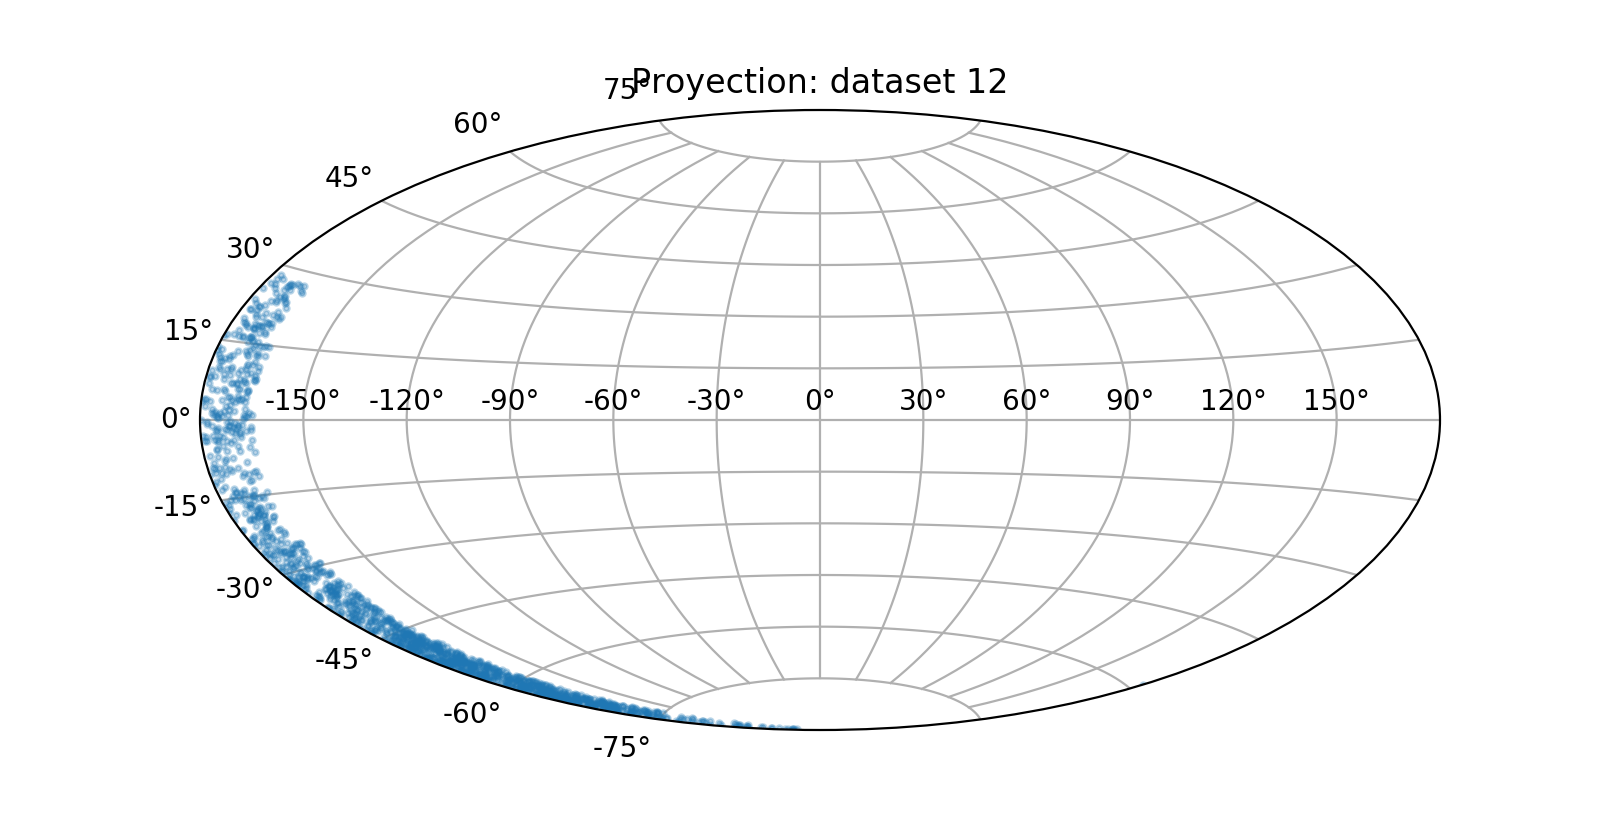

<IPython.core.display.Javascript object>


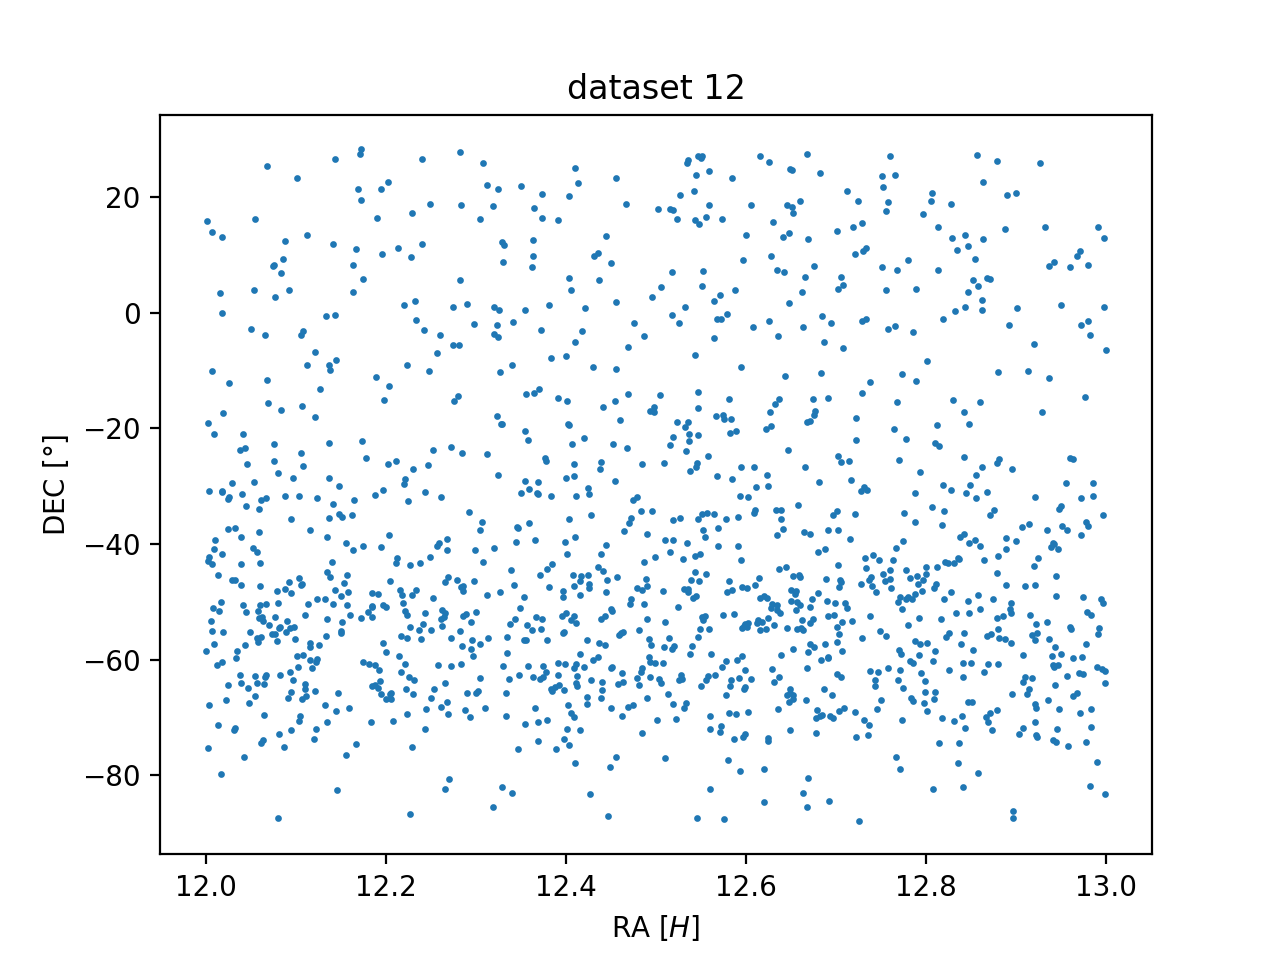

<IPython.core.display.Javascript object>


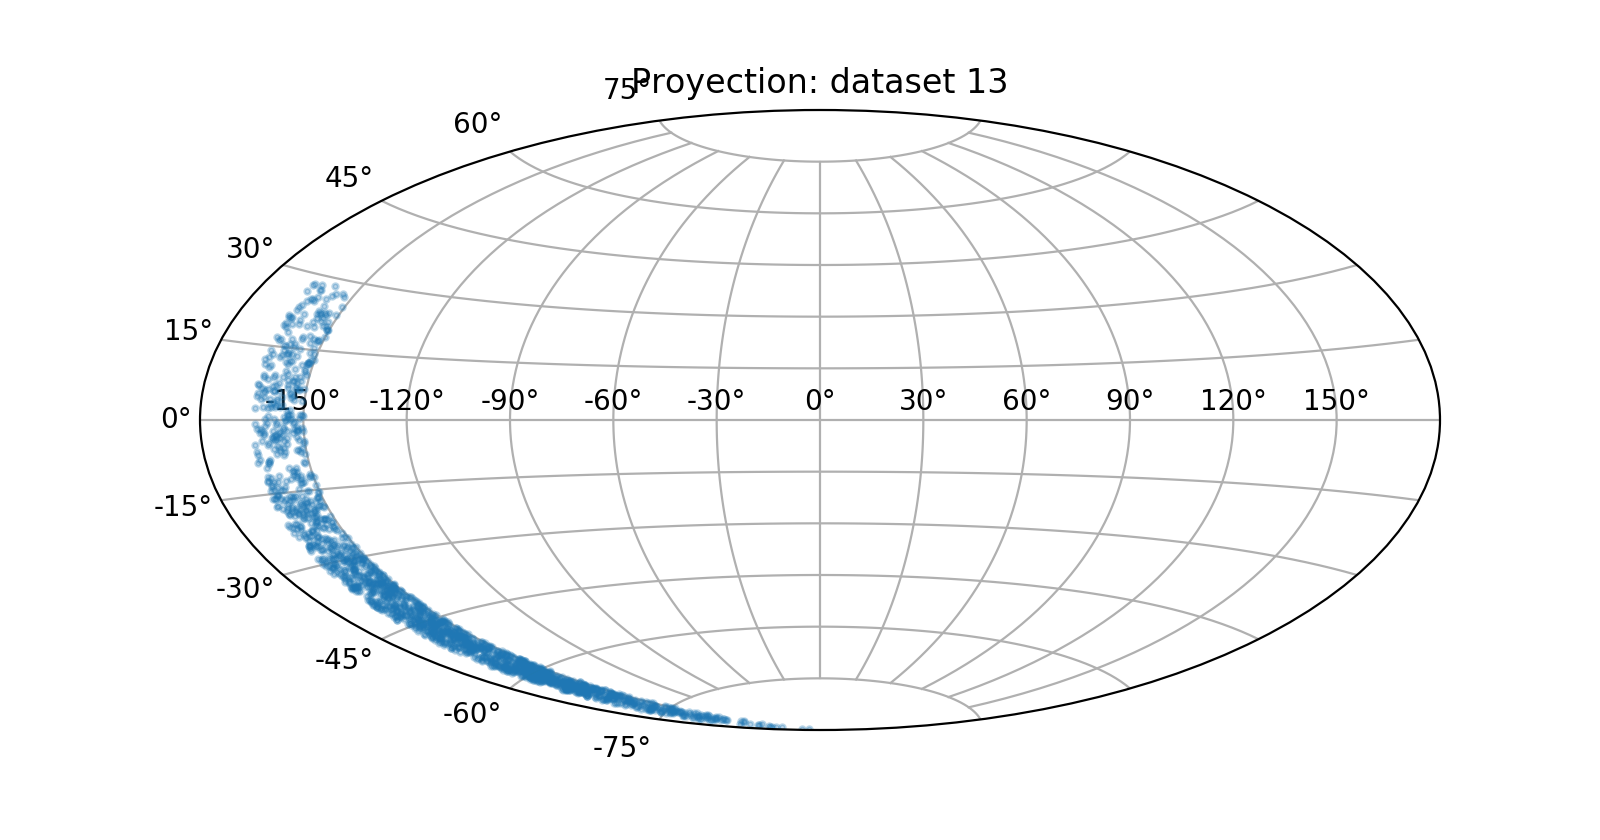

<IPython.core.display.Javascript object>


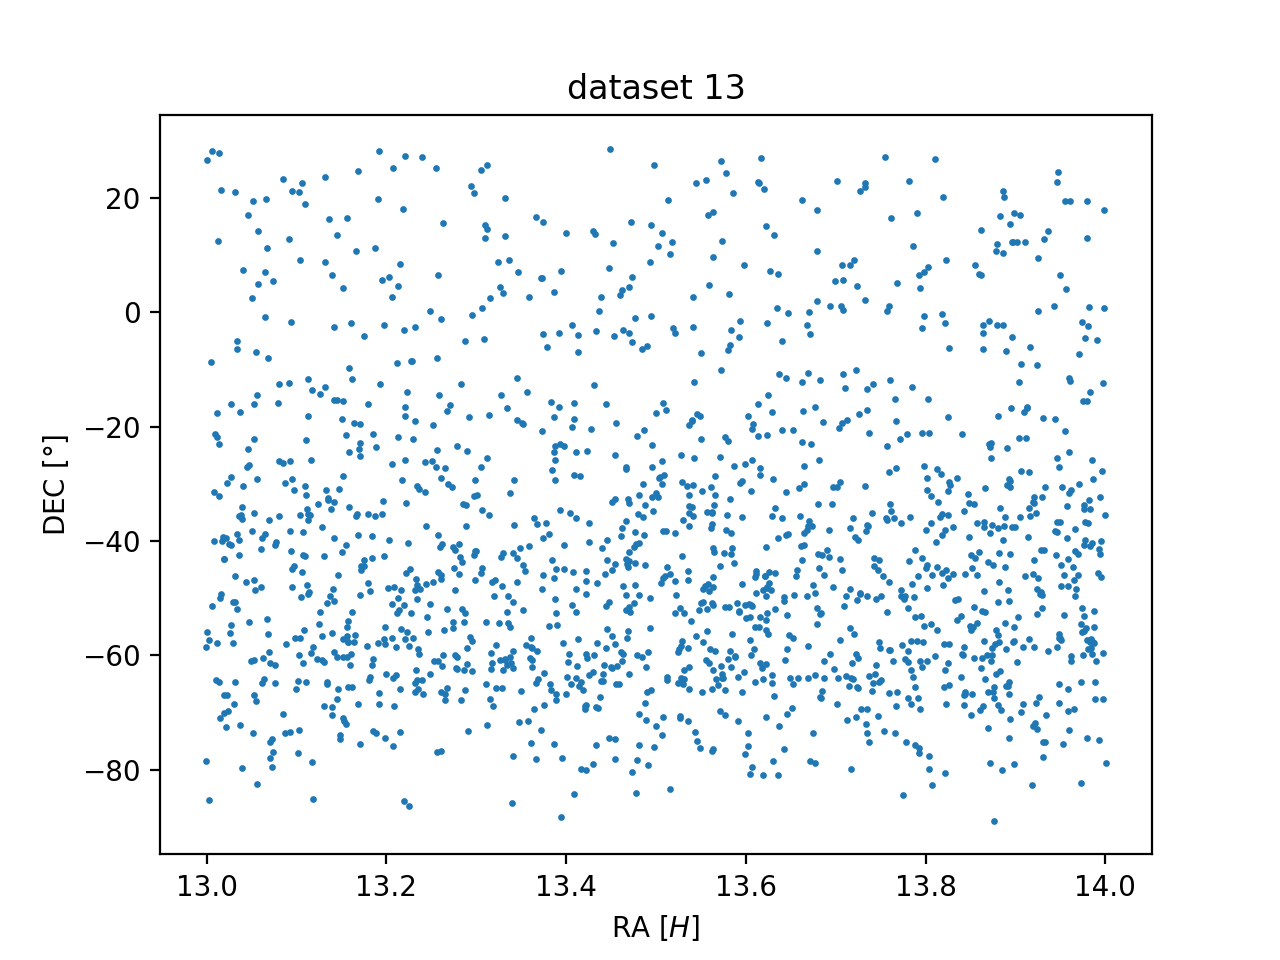

<IPython.core.display.Javascript object>


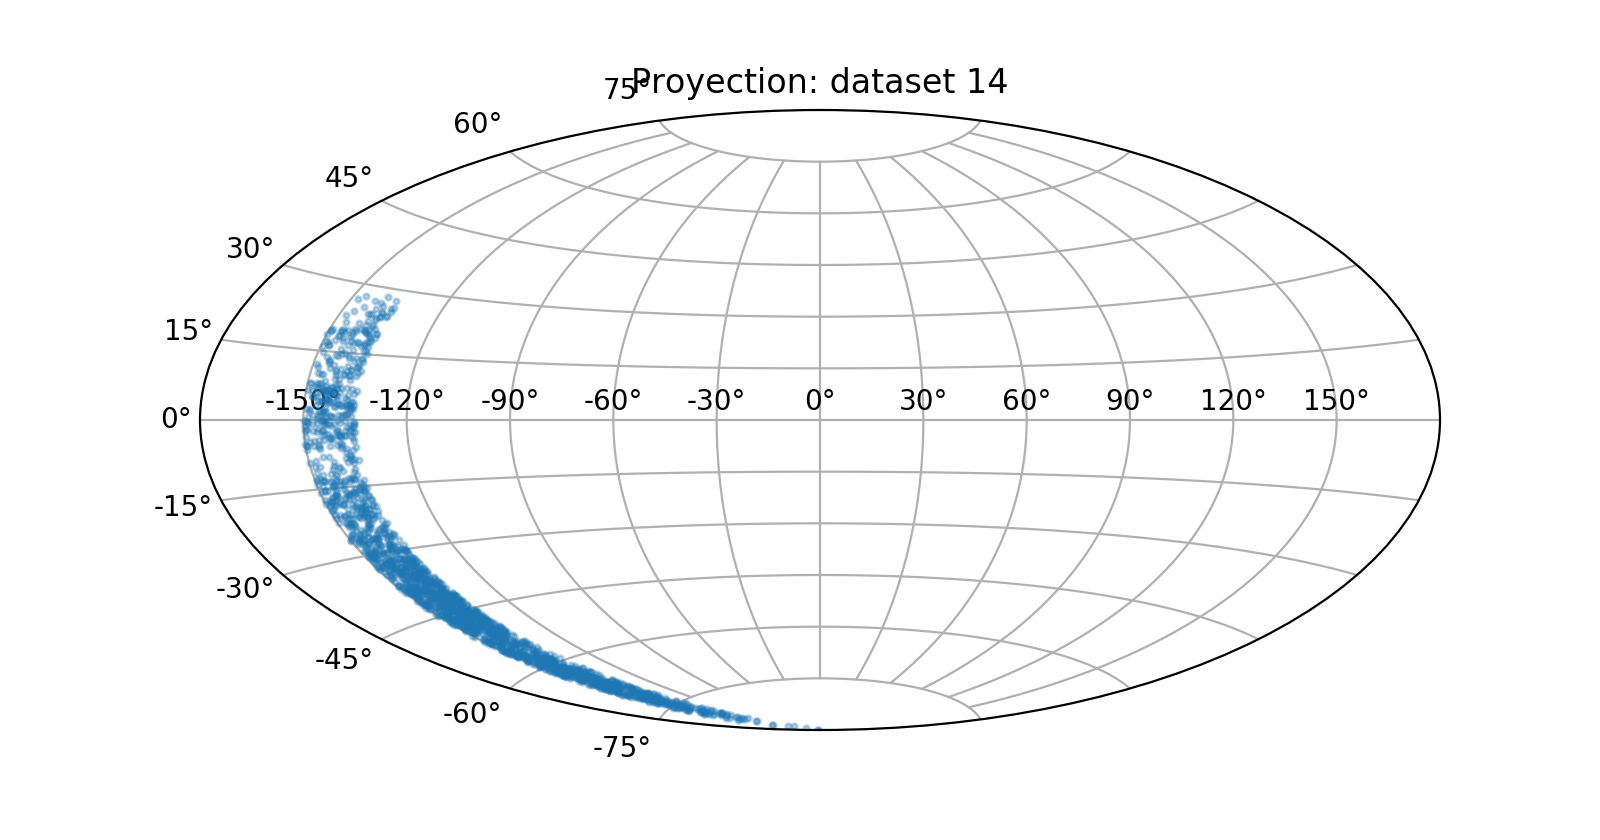

<IPython.core.display.Javascript object>


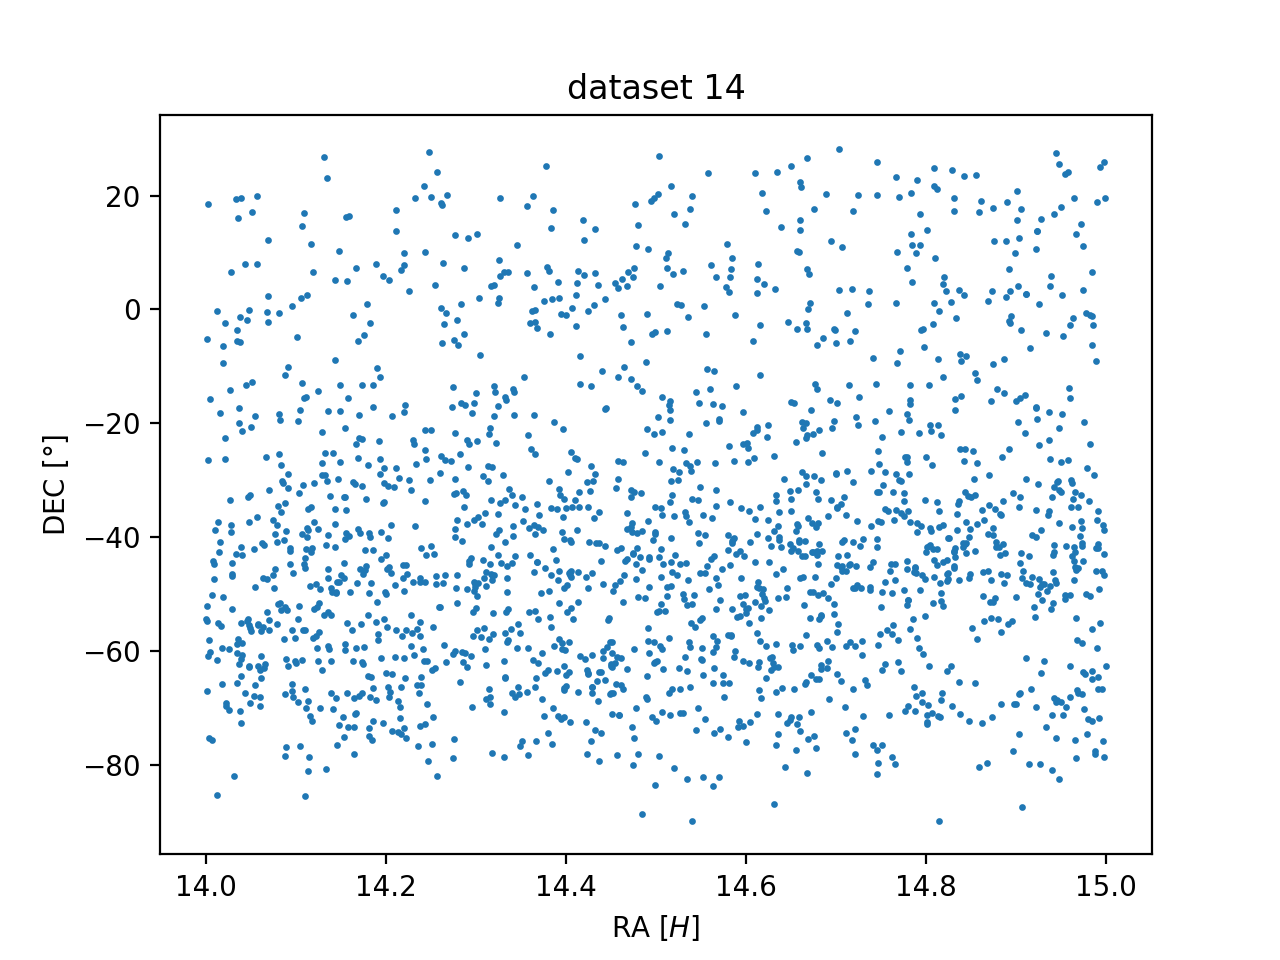

<IPython.core.display.Javascript object>


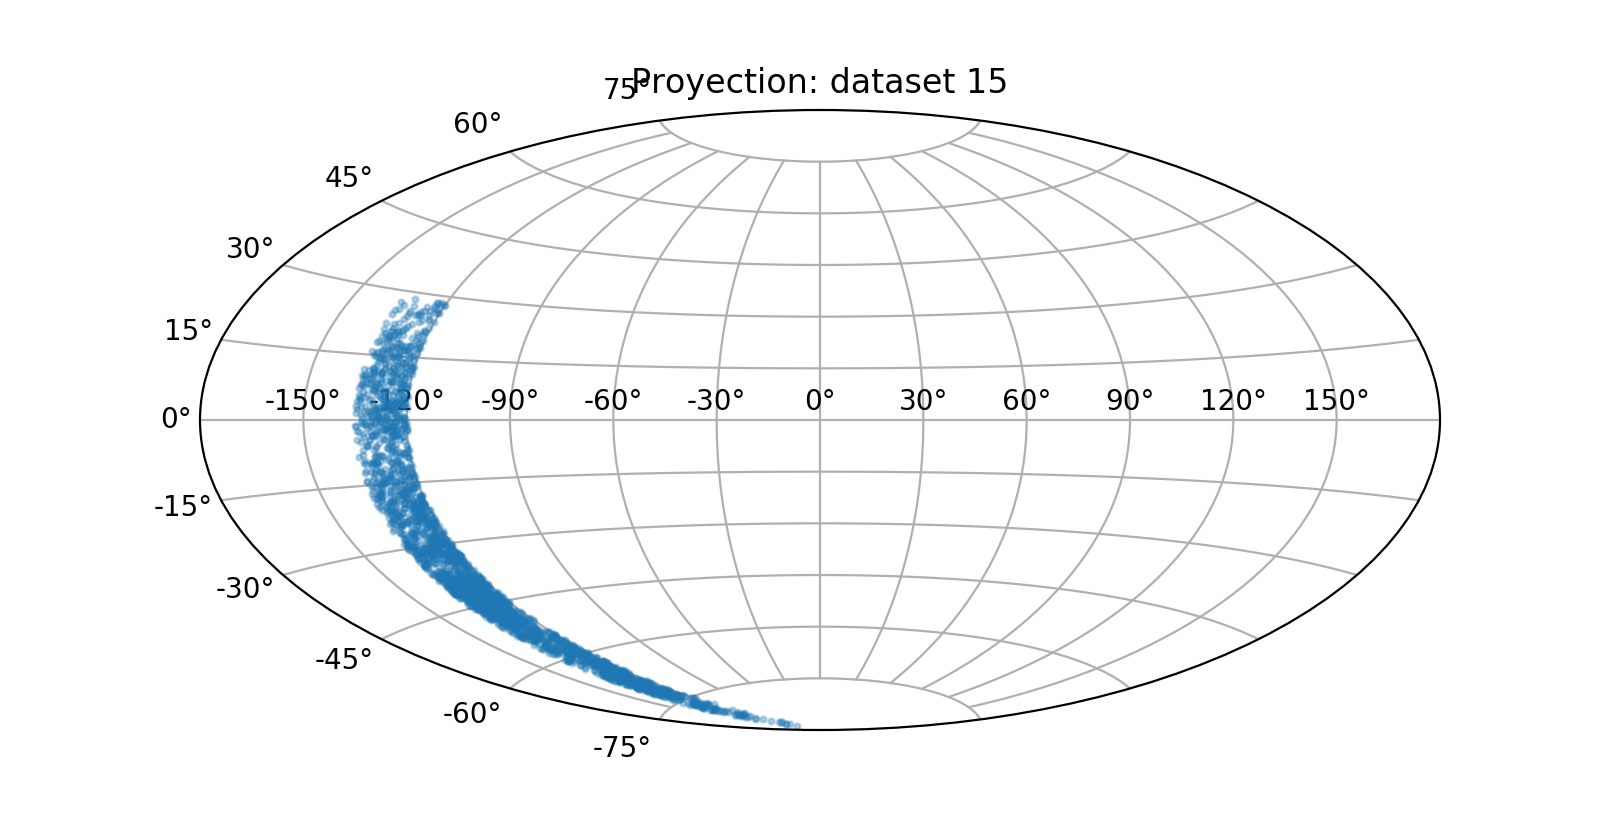

<IPython.core.display.Javascript object>


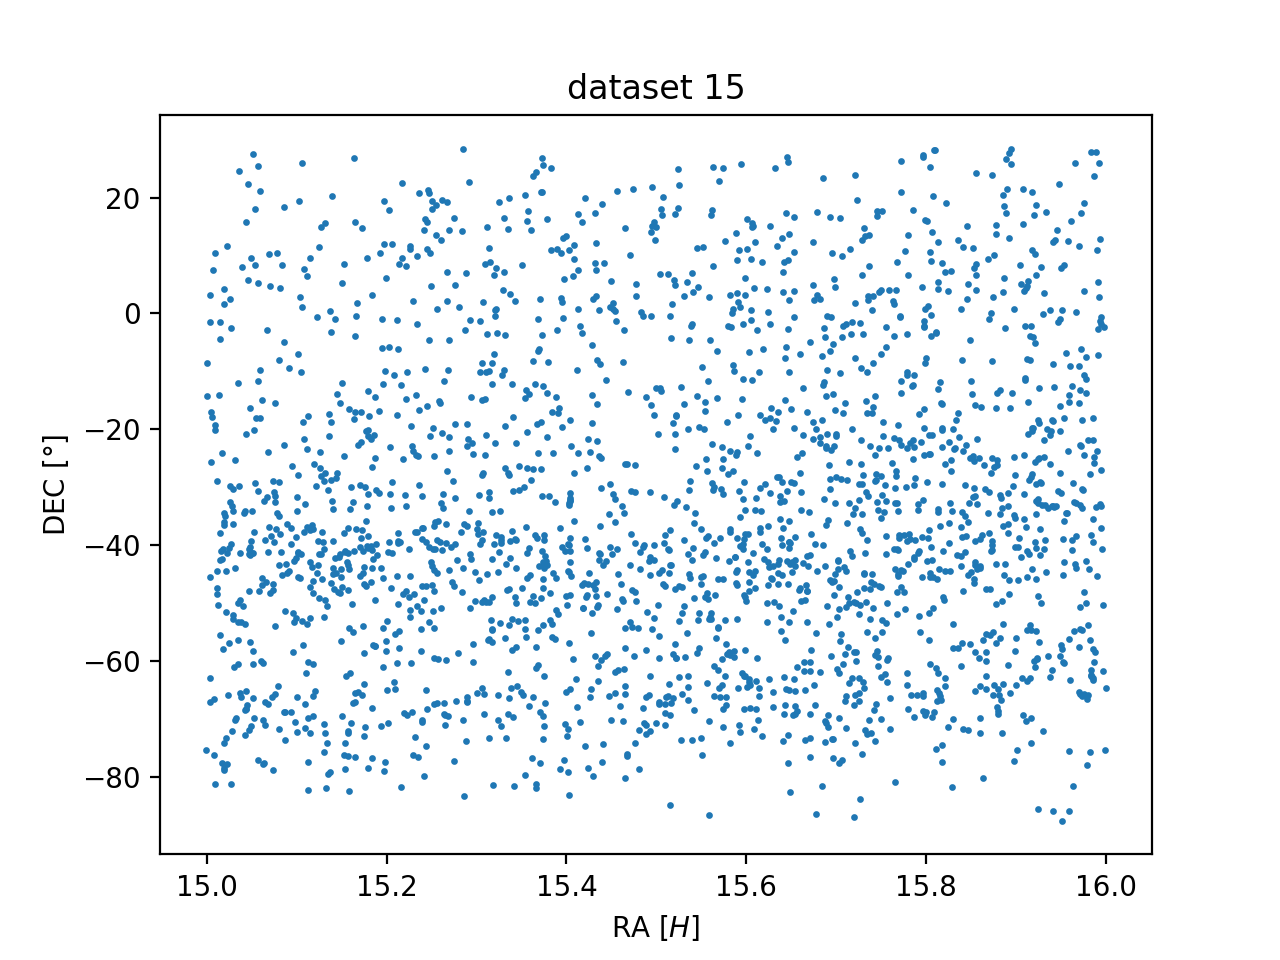

<IPython.core.display.Javascript object>


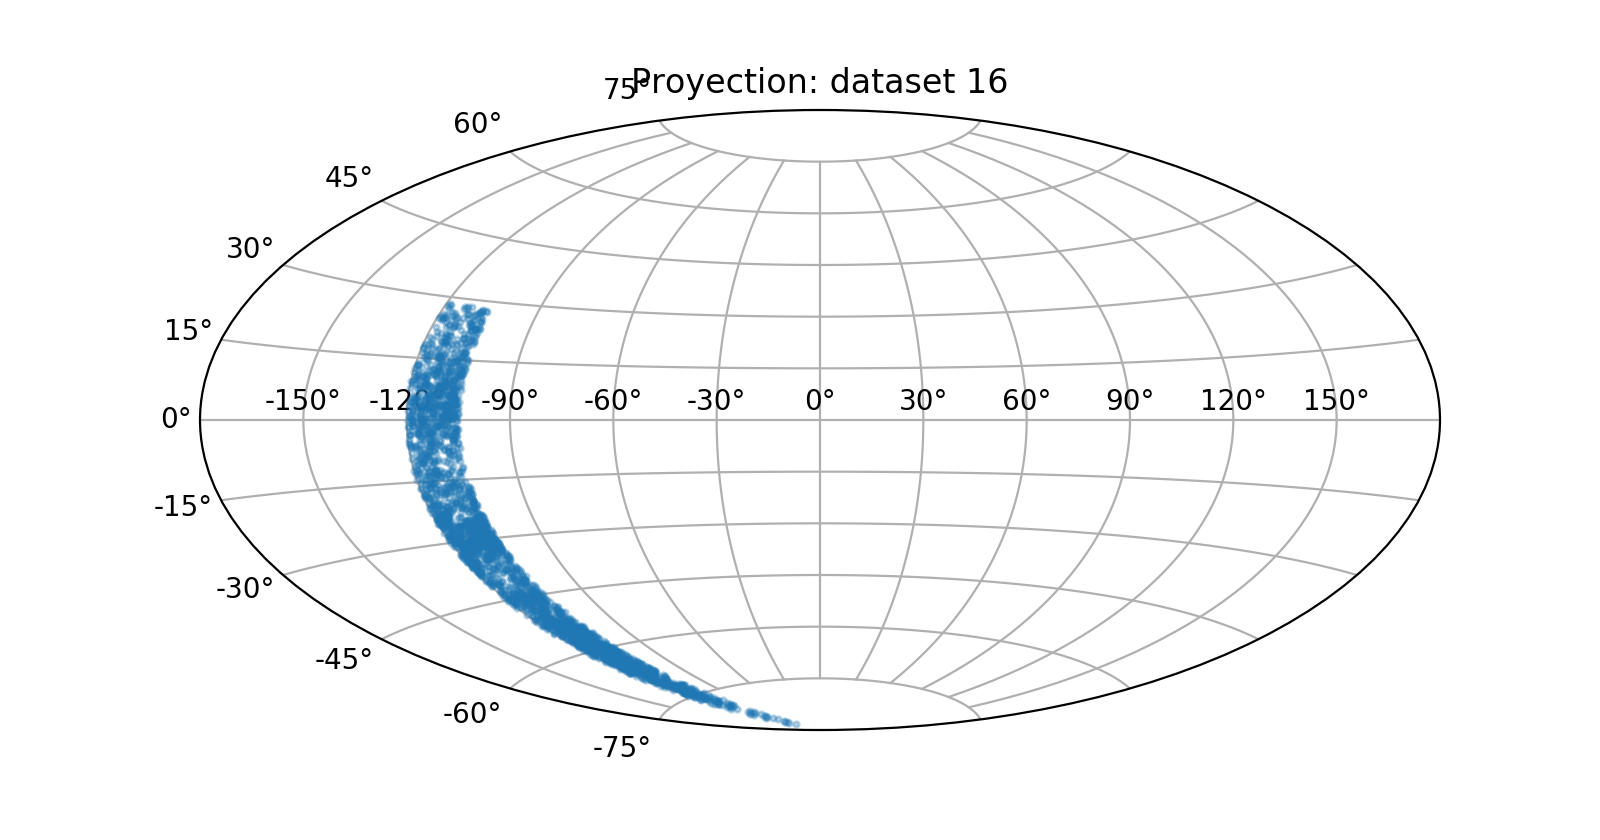

<IPython.core.display.Javascript object>


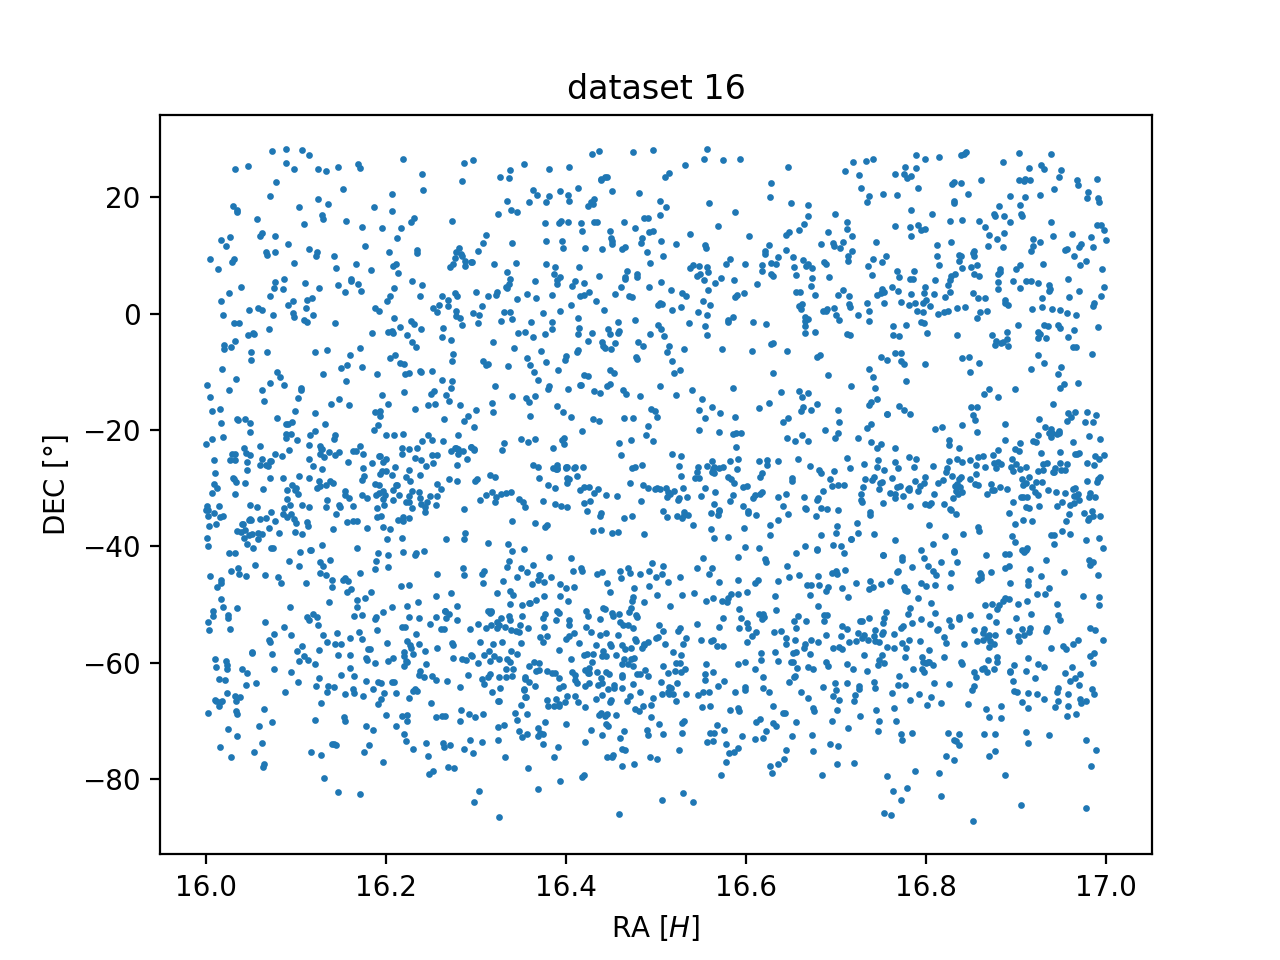

<IPython.core.display.Javascript object>


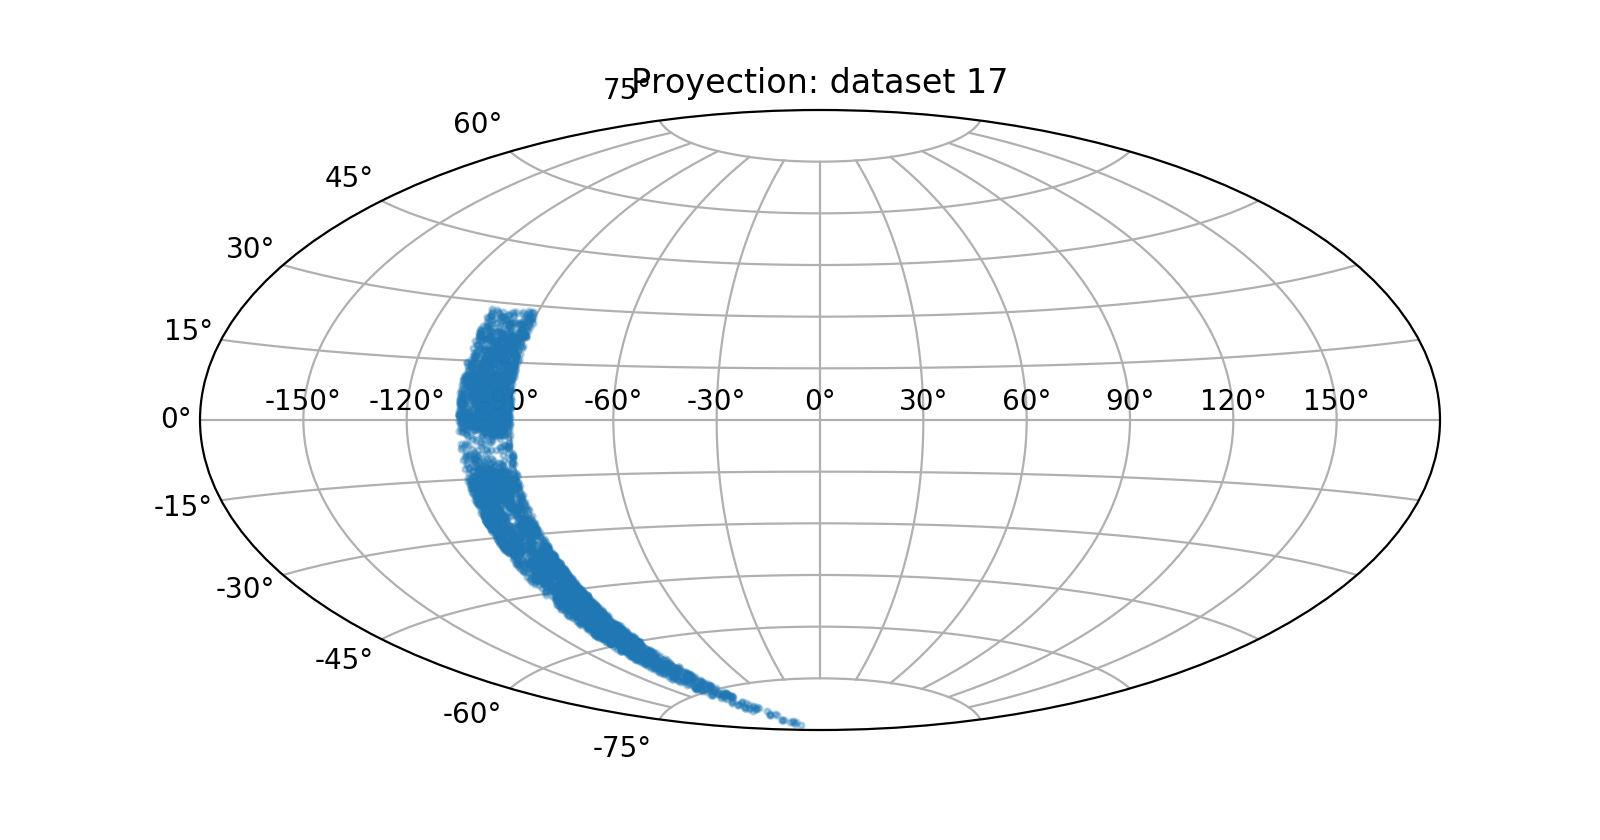

<IPython.core.display.Javascript object>


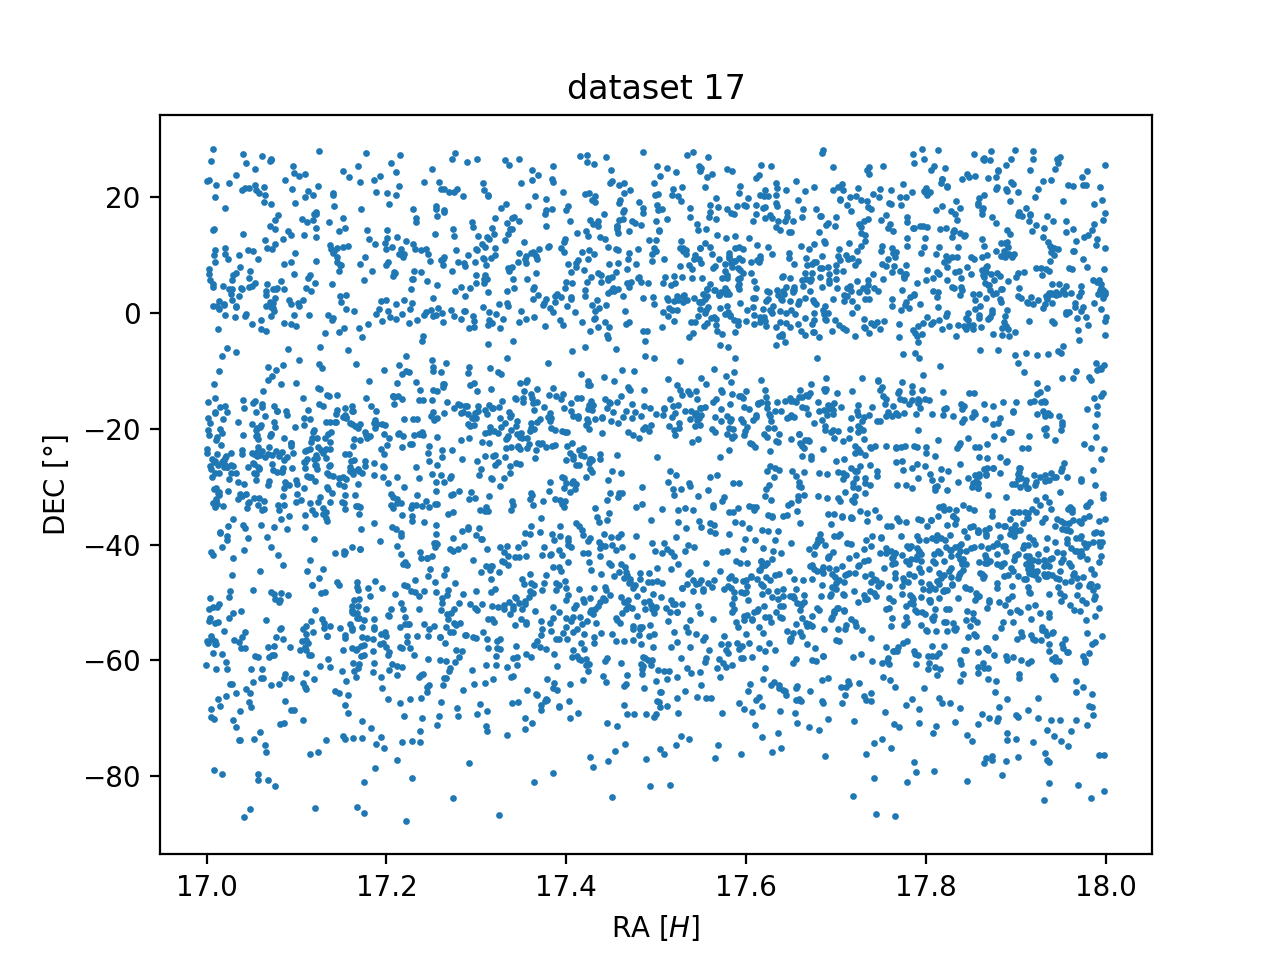

<IPython.core.display.Javascript object>


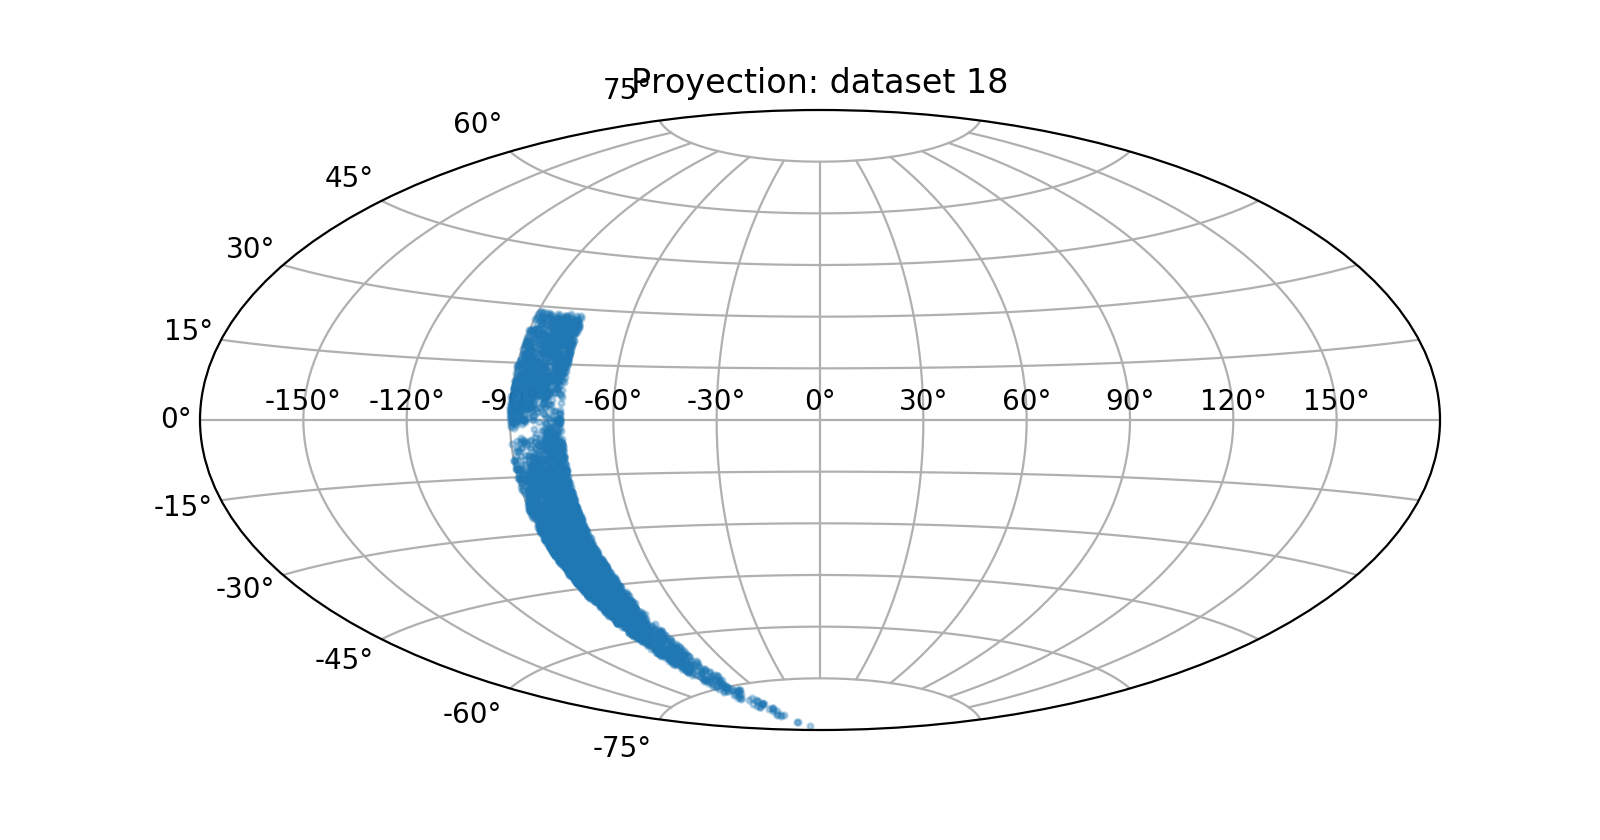

<IPython.core.display.Javascript object>


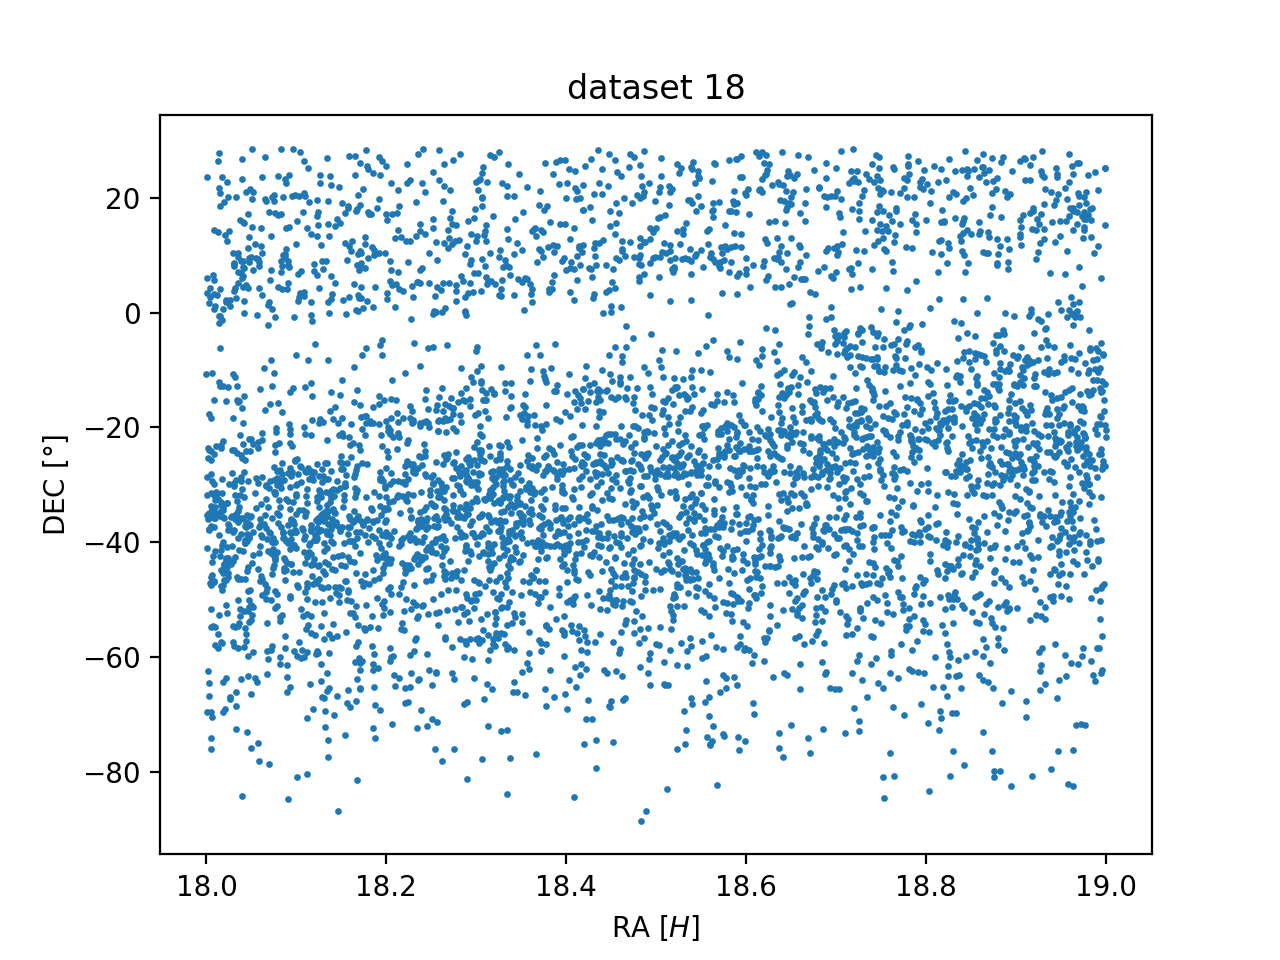

<IPython.core.display.Javascript object>


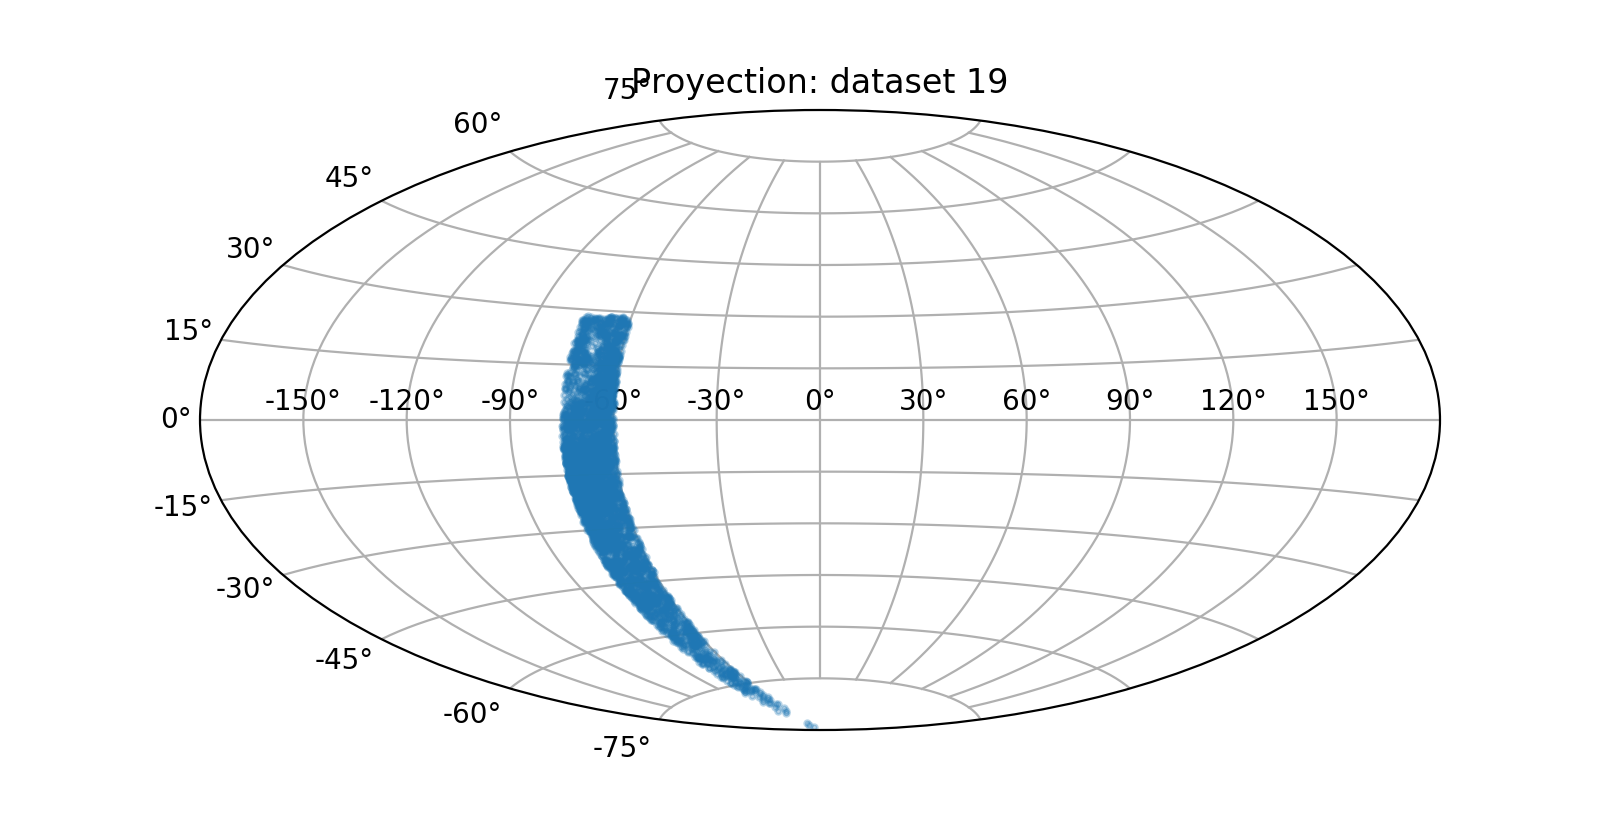

<IPython.core.display.Javascript object>


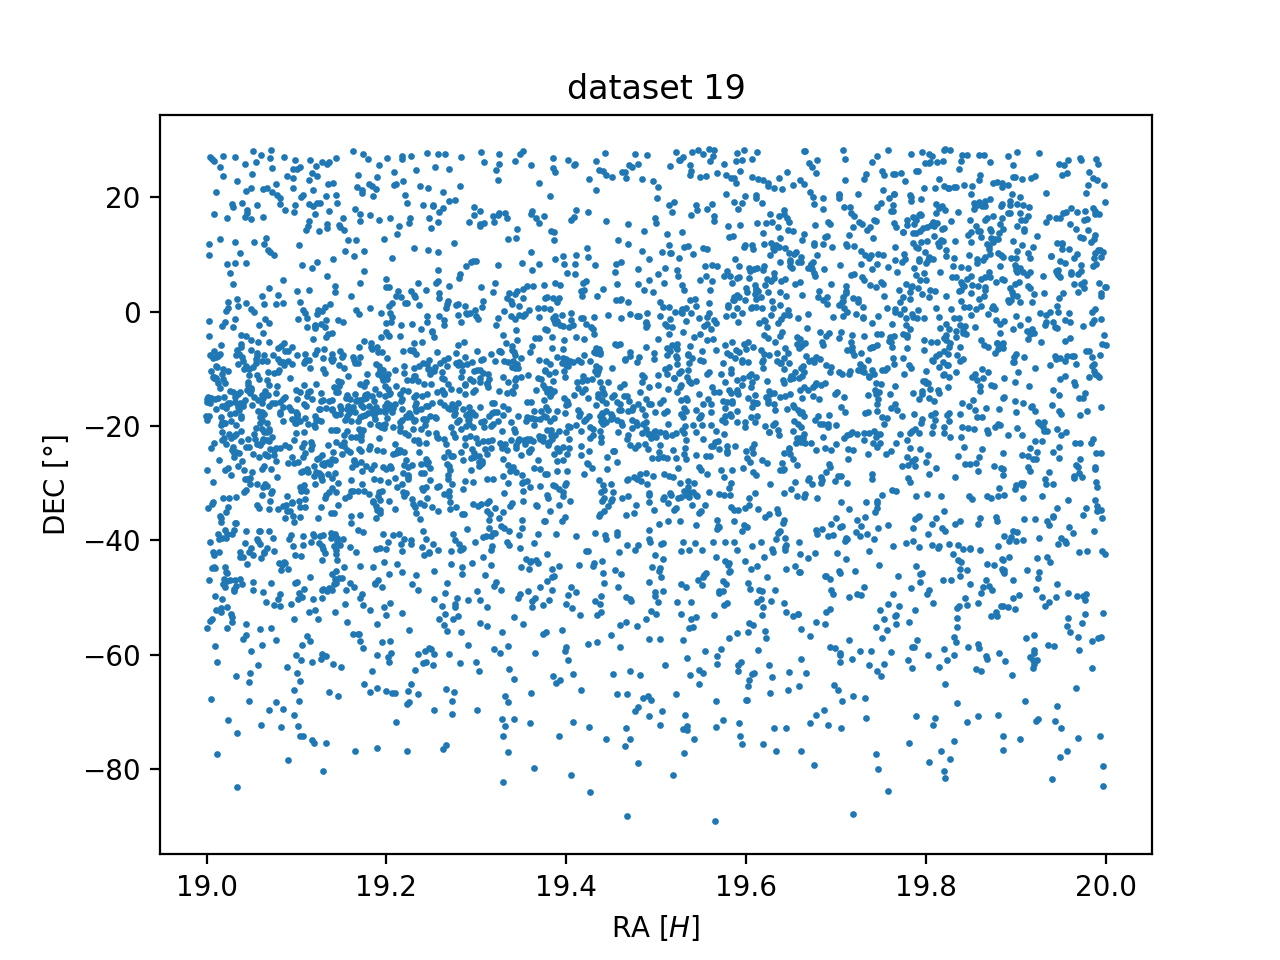

<IPython.core.display.Javascript object>


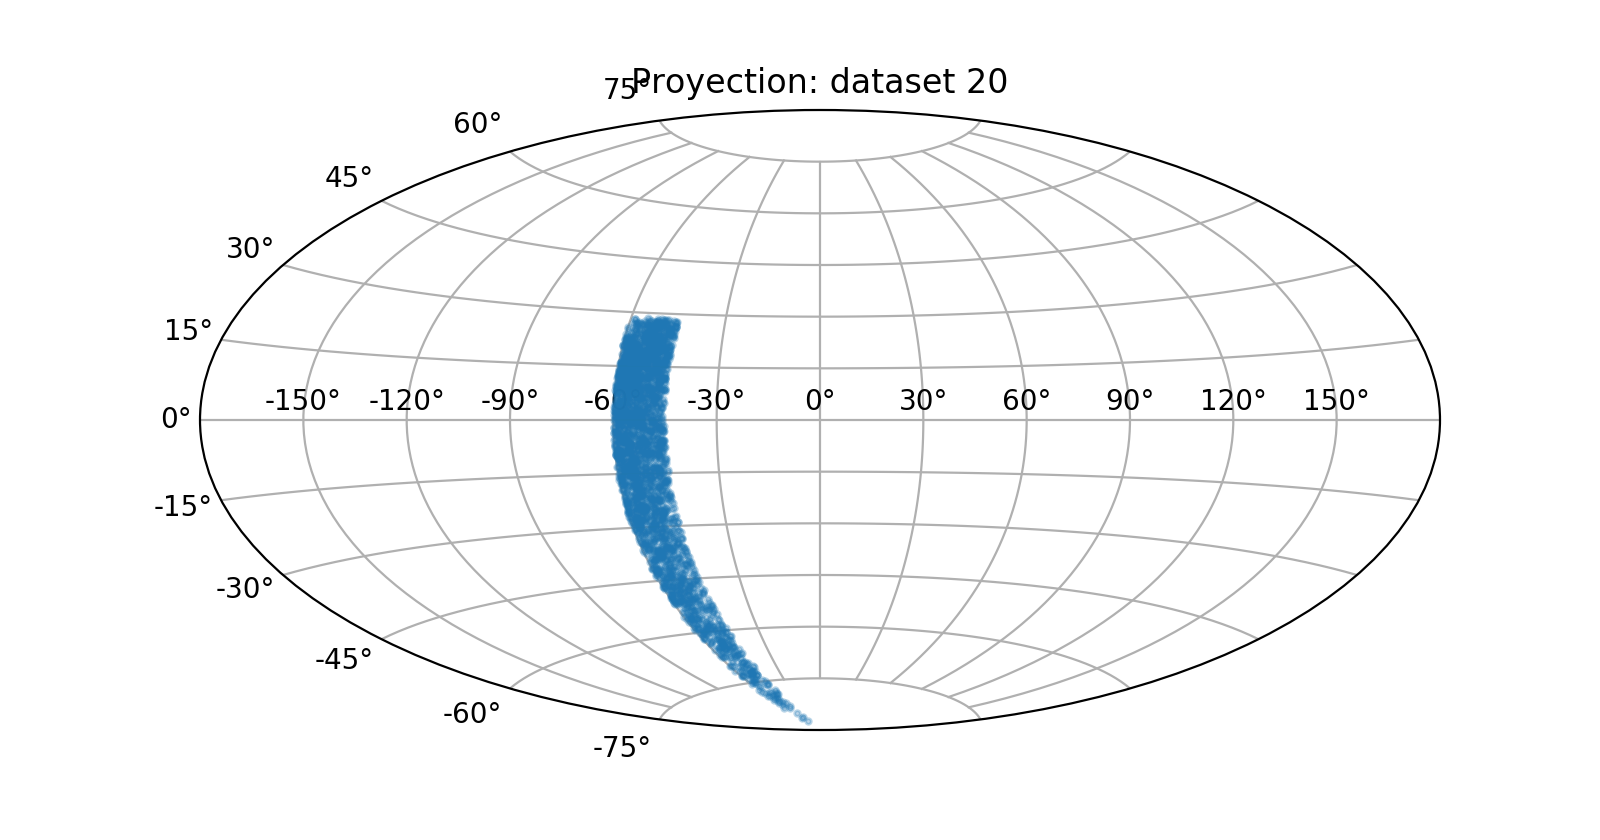

<IPython.core.display.Javascript object>


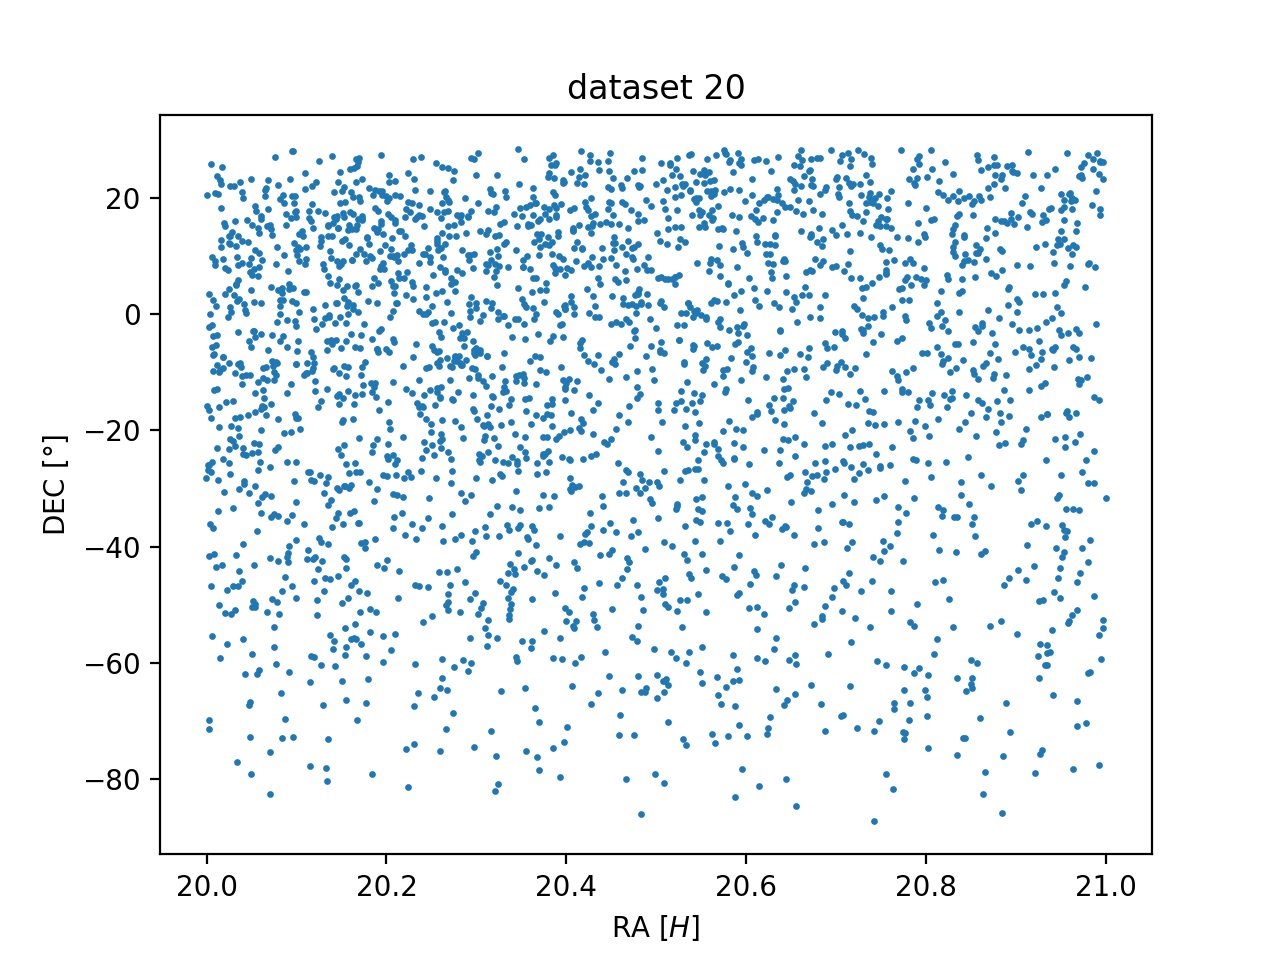

<IPython.core.display.Javascript object>


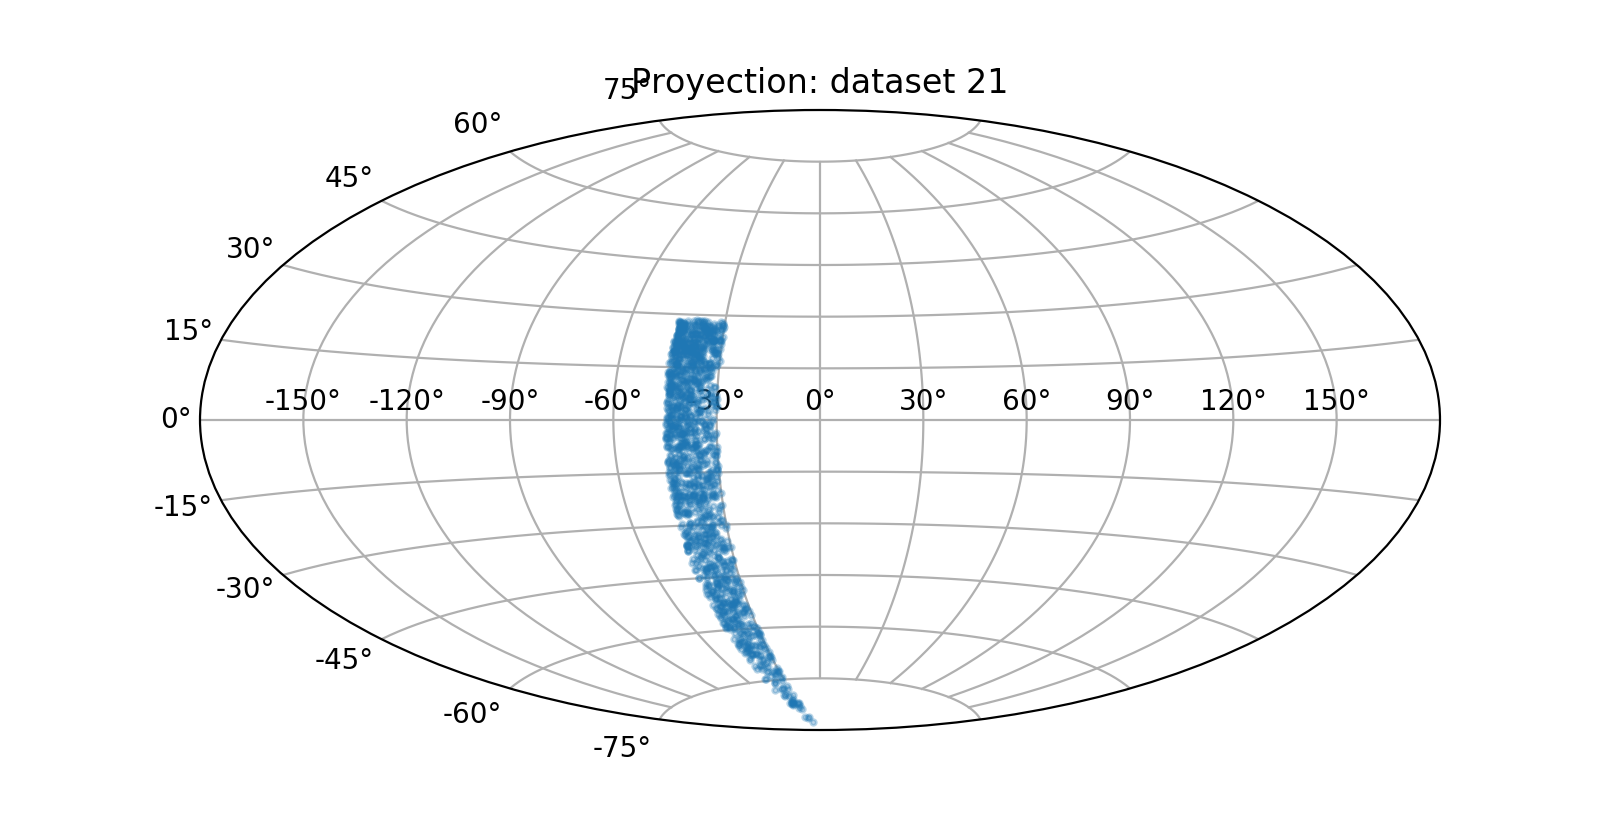

<IPython.core.display.Javascript object>


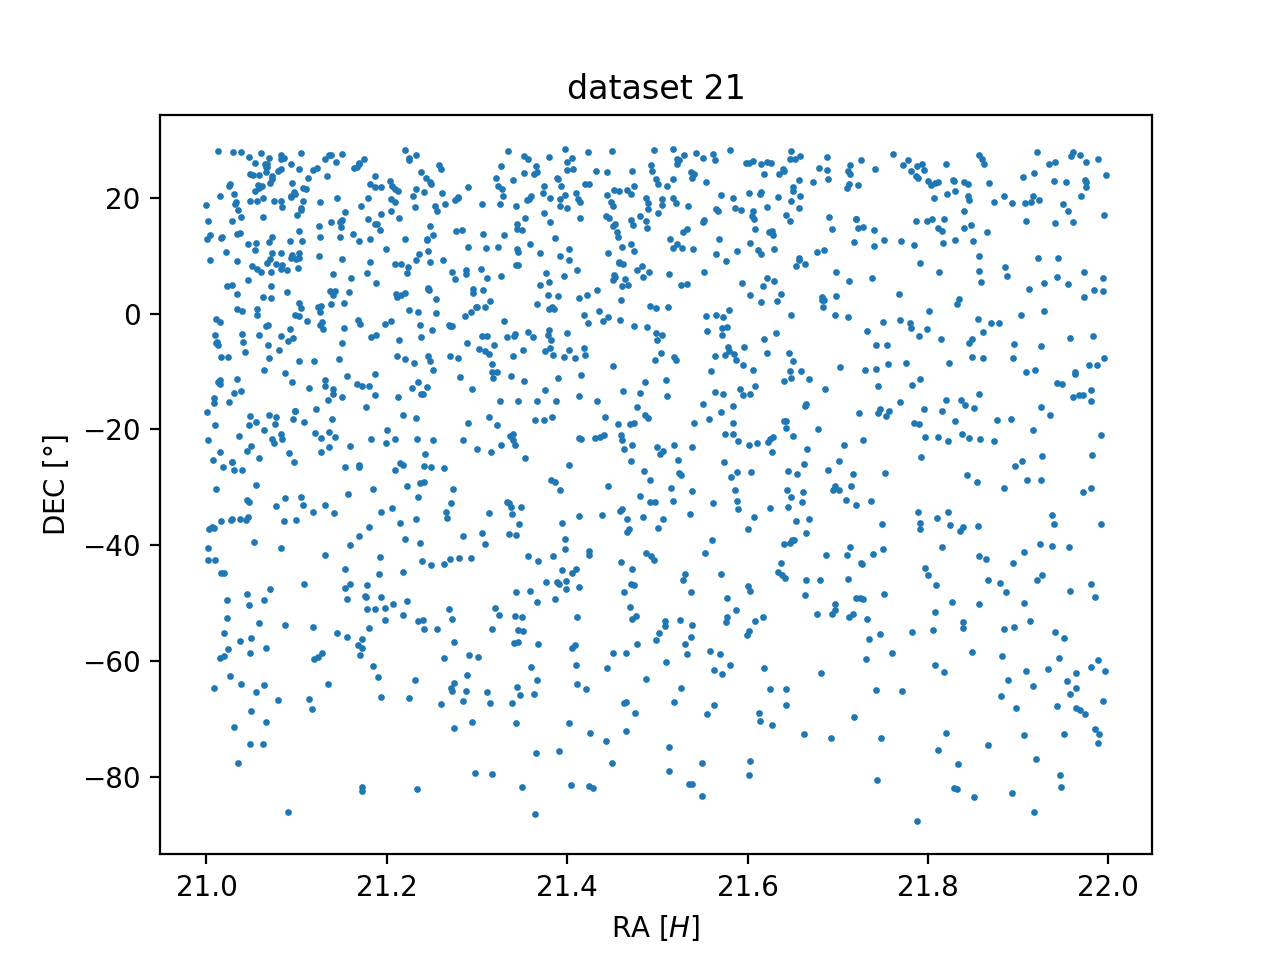

/home/fabricio/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


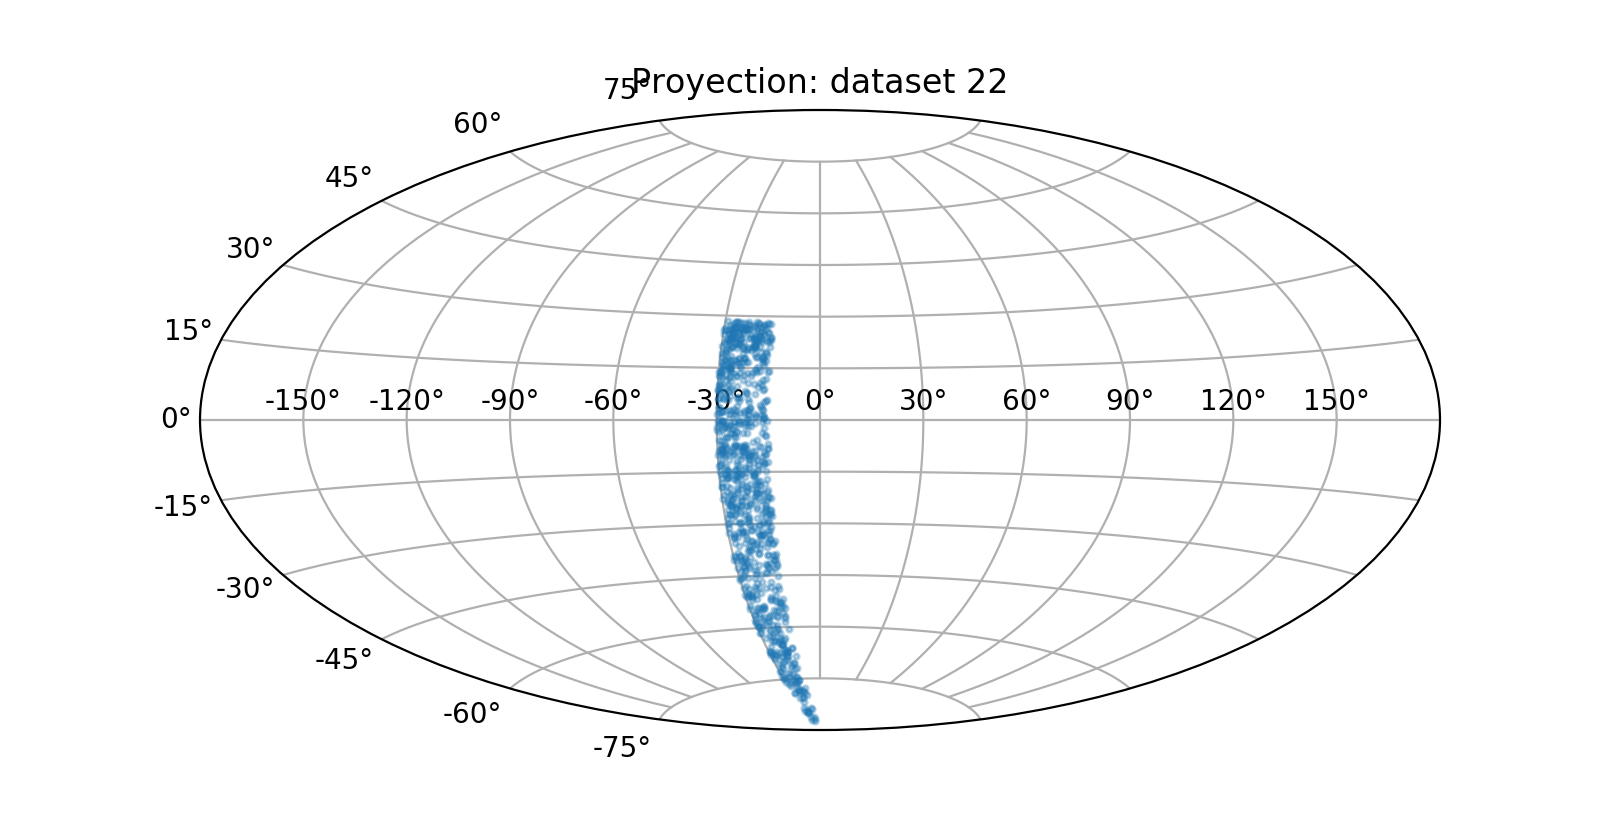

<IPython.core.display.Javascript object>


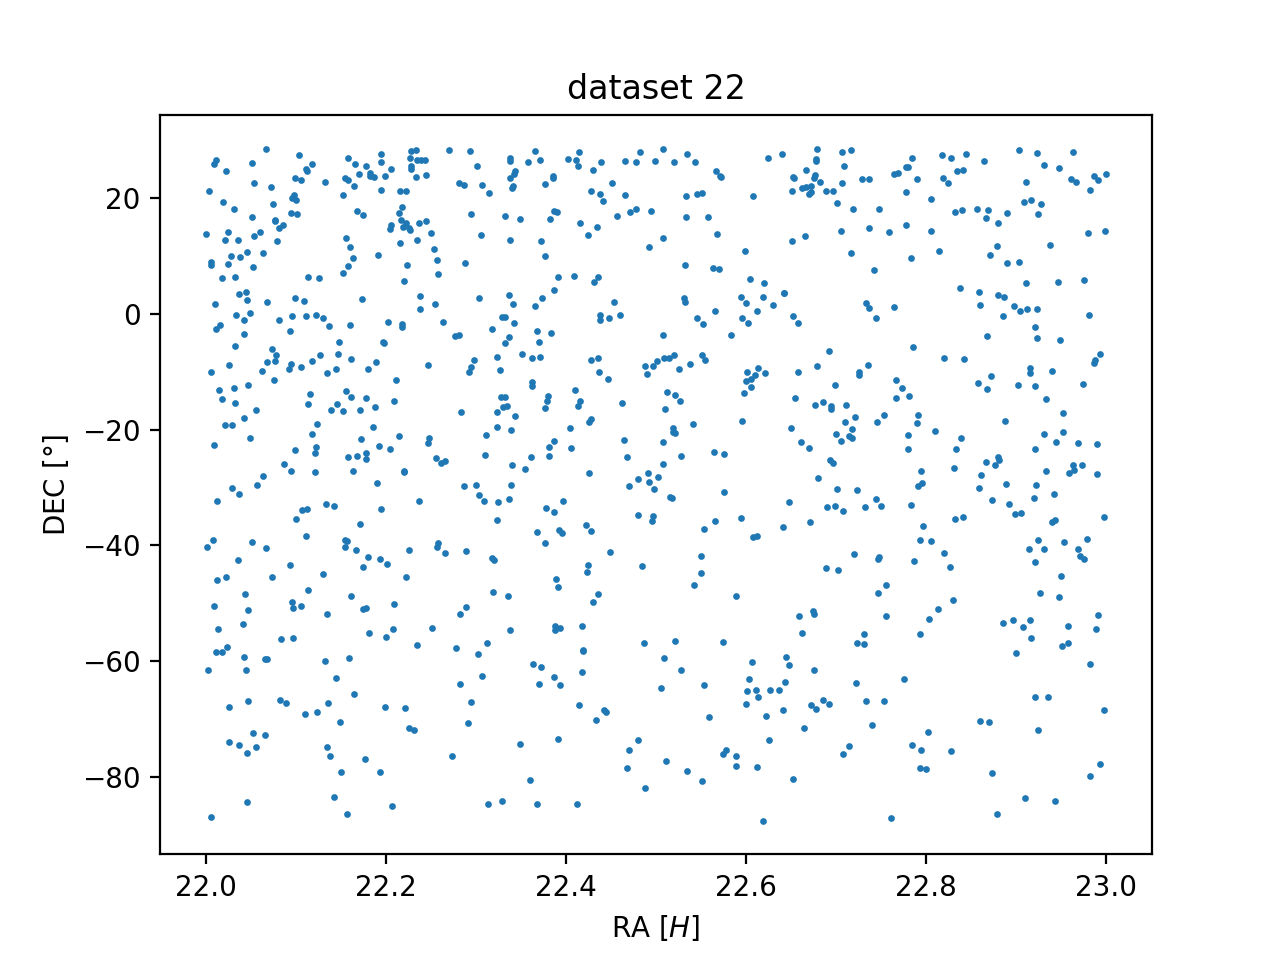

<IPython.core.display.Javascript object>


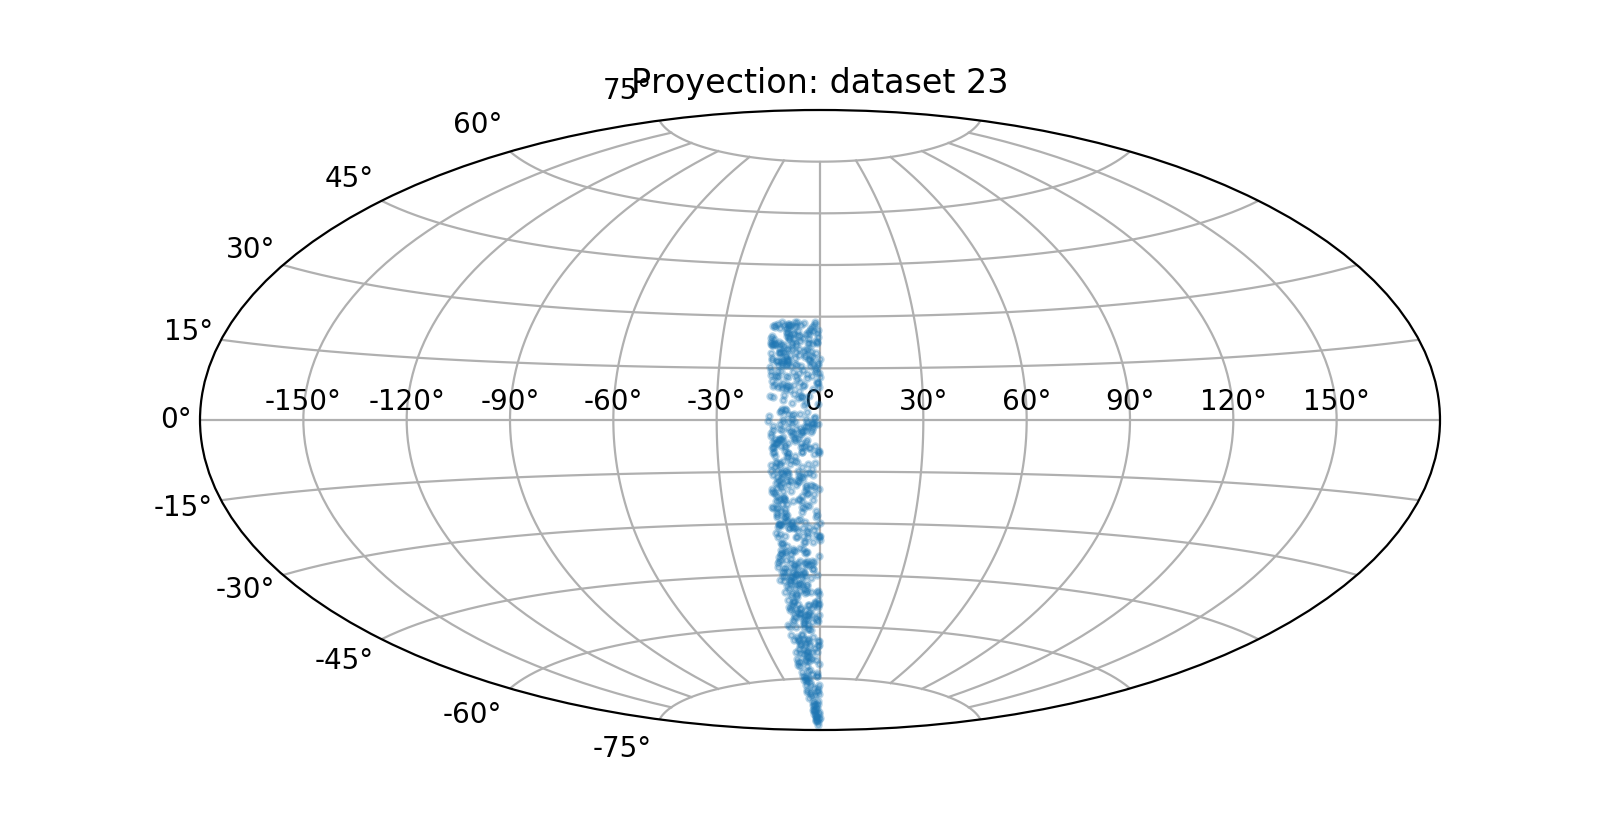

<IPython.core.display.Javascript object>


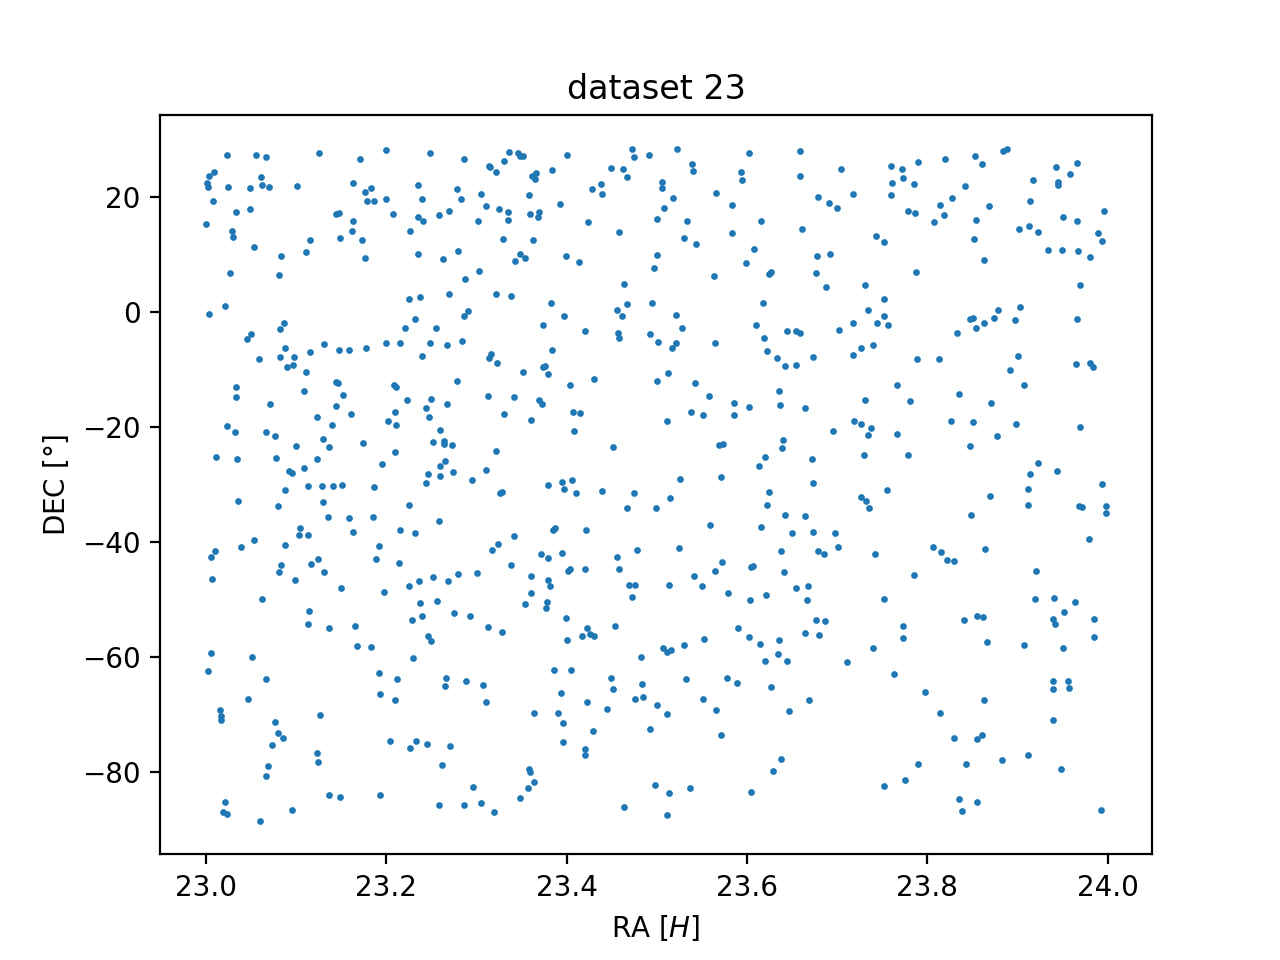

In [8]:
########################Para analizar RA y DEC del dataset de ejemplo##########################
import os
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib notebook
import matplotlib.pyplot as plt
for i in range(12,24):
    num = str(i)
    path = "../"+num+"/"
    rows = []
    for filename in os.listdir(path):
        try:
            file = open(path+filename,"r")
            text = file.readlines()
            if not (os.stat(path+filename).st_size == 0):
                t = parser(text,0)
                file.close()
                if t!=-1:
                    rows.append(get_ra_dec(t))
        except:
            print("Error reading: "+filename)
    res = Table(rows=rows, names=['RA', 'DEC'])
    coord = select_unique(res,['RA', 'DEC'])
    c = SkyCoord(ra=coord[:,0]*u.hour, dec=coord[:,1]*u.degree, frame='icrs')
    ra = coord[:,0] # in hours
    dec = coord[:,1] # in degrees
    #ra_rad = ra*2*np.pi/24*u.radian
    #ra_rad[ra_rad > np.pi*u.radian] -= 2. * np.pi
    #dec_rad = dec*np.pi/180*u.radian
    ra_rad = c.ra.radian
    ra_rad[ra_rad > np.pi] -= 2. * np.pi
    plt.figure(figsize=(8,4.2))
    plt.subplot(111, projection="aitoff")
    plt.title("Proyection: dataset "+num)
    plt.grid(True)
    plt.plot(ra_rad,c.dec.radian, 'o', markersize=2, alpha=0.3)
    plt.subplots_adjust(top=1,bottom=0.0)
    plt.savefig("../graficos/"+num+".png")
    plt.figure()
    plt.scatter(c.ra.hour, c.dec.degree, s=2)
    plt.title("dataset "+num)
    plt.ylabel("DEC $[°]$")
    plt.xlabel("RA $[H]$")
    plt.savefig("../graficos/data_"+num+".png")

In [2]:
c.ra.hour

NameError: name 'c' is not defined

In [47]:
from astropy import units as u
from astropy.coordinates import SkyCoord
coord = select_unique(res,['RA', 'DEC'])
c = SkyCoord(ra=coord[:,0]*u.degree, dec=coord[:,1]*u.degree, frame='icrs')
#ra_rad = c.ra.radian
#dec_rad = c.dec.radian
#ra_rad[ra_rad > np.pi] -= 2. * np.pi
ra = coord[:,0] # in hours
dec = coord[:,1] # in degrees
ra_rad = ra*2*np.pi/24*u.radian
ra_rad[ra_rad > np.pi] -= 2. * np.pi
dec_rad = dec*np.pi/180*u.radian

<IPython.core.display.Javascript object>


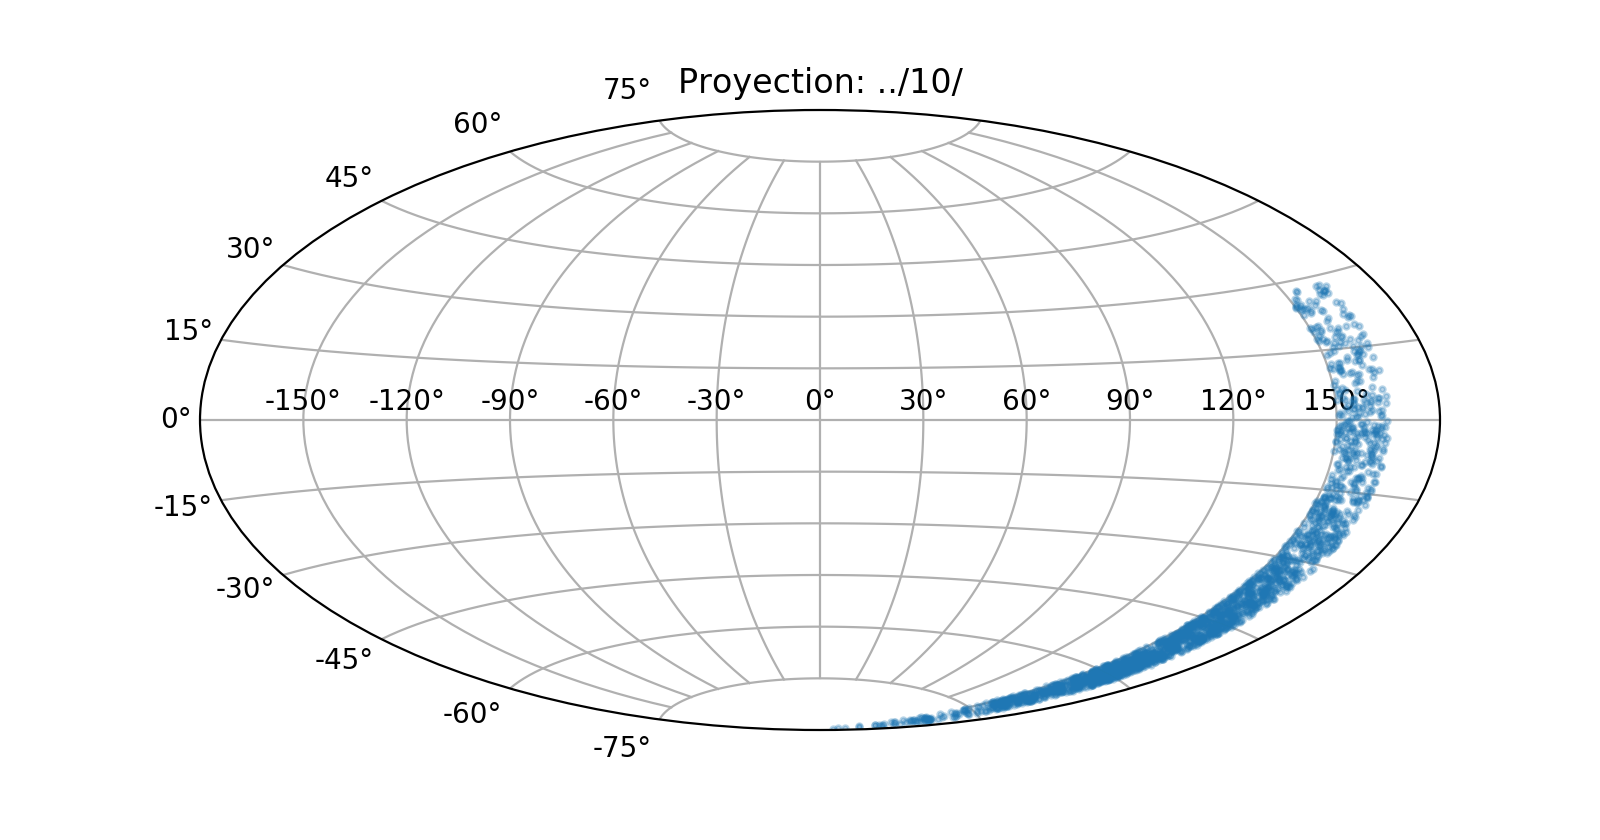

In [50]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Proyection: "+path)
plt.grid(True)
plt.plot(ra_rad,dec_rad, 'o', markersize=2, alpha=0.3)
plt.subplots_adjust(top=1,bottom=0.0)
plt.show()
plt.savefig("../graficos/"+num+".png")

<IPython.core.display.Javascript object>


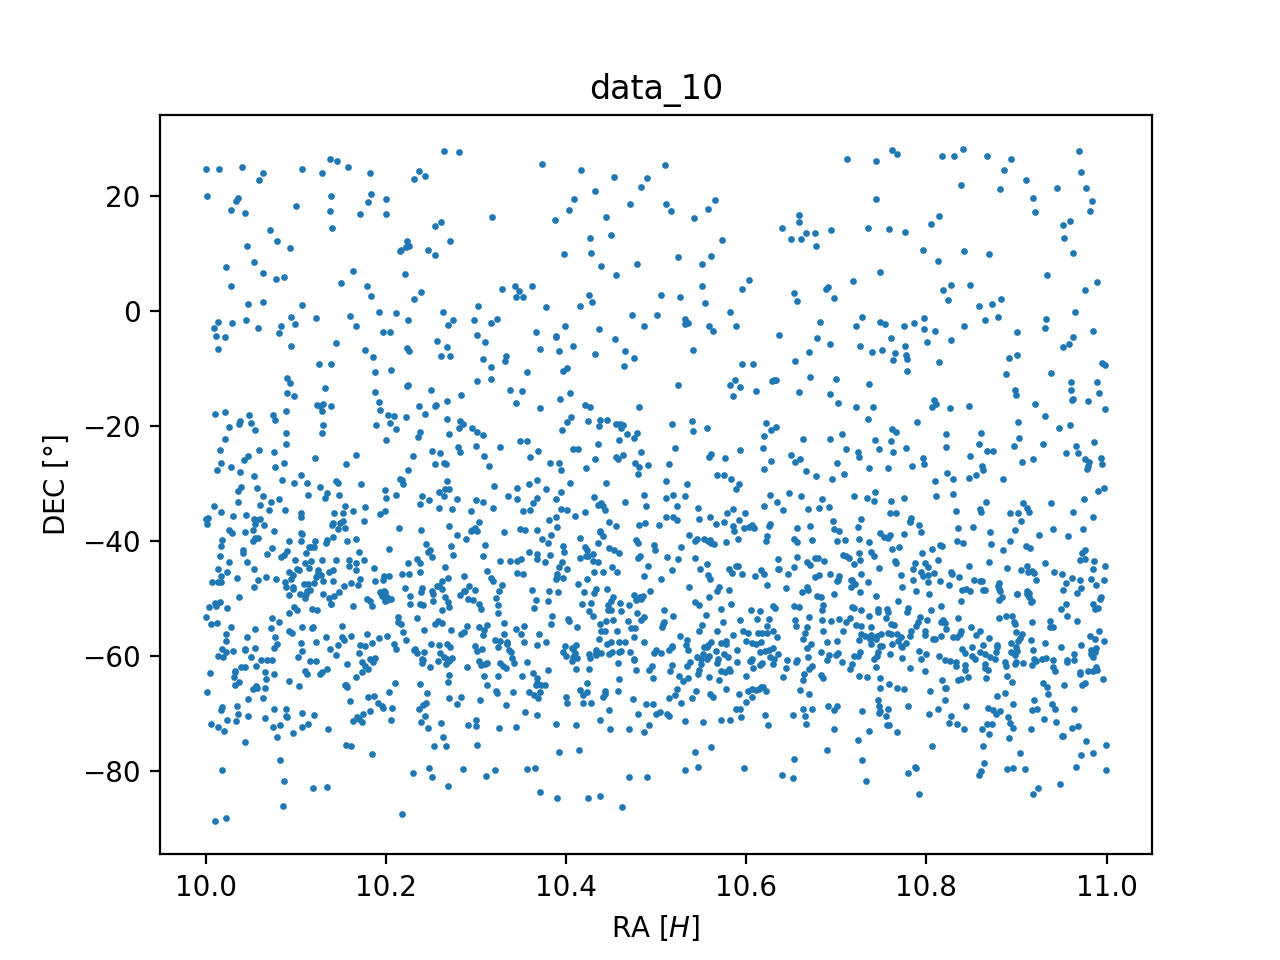

In [51]:
plt.figure()
plt.scatter(ra, dec, s=2)
plt.show()
plt.title("data_"+num)
plt.ylabel("DEC $[°]$")
plt.xlabel("RA $[H]$")
plt.savefig("../graficos/data_"+num+".png")

In [ ]:
dec

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def Sort(tup): 
    # reverse = True (Sorts in Descending order) 
    # key is set to sort using float elements 
    # lambda has been used 
    return(sorted(tup, key = lambda x: float(x[0]), reverse = True)) 
res = Sort(res)

fig, ax = plt.subplots()
ax.scatter(res[0],res[1])

ax.set(xlabel='HJD', ylabel='Magnitude',
       title='Test')
ax.grid()

fig.savefig("test/test"+str(counter)+".png")
plt.show()


In [ ]:
np.array(alpha)

In [ ]:
t = Table(np.c_[rows,np.array(alpha),np.array(gamma)], names=tuple(col[0],'RA','DEC'), dtype = ('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','S1','f8'))


In [ ]:
col[0]

In [ ]:
data = [ '#nskip_4= 0\n',
 '#ra=   17.000018  17:00:00.1\n',
 '#dec= -24.121600 -24:07:17.8\n',
 '#     HJD      MAG_1  MAG_0  MAG_2  MAG_3  MAG_4    MER_1 MER_0 MER_2 MER_3 MER_4 GRADE FRAME\n',
 '   2140.48752 12.253 12.299 12.194 12.162 12.187    0.020 0.038 0.017 0.018 0.021  A 30120\n',
 '   2384.87500 11.893 11.977 11.846 11.806 11.814    0.018 0.034 0.019 0.021 0.024  A 773\n',
 '   2385.89474 11.916 12.083 11.843 11.807 11.784    0.034 0.057 0.032 0.034 0.040  D 984\n']
res = parser(data)
print(res)

In [ ]:
from astropy.table import Table
a = [1, 4, 5]
b = [2.0, 5.0, 8.2]
c = ['x', 'y', 'z']
t = Table([a, b, c], names=('a', 'b', 'c'), meta={'name': 'first table'})

In [ ]:
Table.read("""    HJD      MAG_1  MAG_0  MAG_2  MAG_3  MAG_4    MER_1 MER_0 MER_2 MER_3 MER_4 GRADE FRAME\n
    2140.48752 12.253 12.299 12.194 12.162 12.187    0.020 0.038 0.017 0.018 0.021  A 30120\n
    2384.87500 11.893 11.977 11.846 11.806 11.814    0.018 0.034 0.019 0.021 0.024  A 773\n
    2385.89474 11.916 12.083 11.843 11.807 11.784    0.034 0.057 0.032 0.034 0.040  D 984\n""", format='ascii')